In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from qick import *
from qick.helpers import gauss
from tqdm import tqdm_notebook as tqdm

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
from scipy.fft import fft, fftfreq
import json

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

# Figure params
plt.rcParams['figure.figsize'] = [10,6]
plt.rcParams.update({'font.size': 14})

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


# Load experiments

In [2]:
# %aimport experiments
import experiments as meas

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_ef_spectroscopy
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_echo
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_pi_pulse_ZZ
imported experiments.two_qubit.pulse_probe_coupling_spectroscopy


In [3]:
"""Reopen saved data"""
def prev_data(expt_path, filename):
    temp_data_file = expt_path+'/'+filename
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [4]:
expt_path=os.path.join(os.getcwd(),'data', 'data_231212')
print('Data will be stored in', expt_path)

Data will be stored in s:\Connie\experiments\qramLL_4QR2\data\data_231212


In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join(os.getcwd(), config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


Load config

In [6]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

# Setup experiment hardware

Set in config:
- LO alias, frequency, power
- SOC dac channels, nyquist zones

In [7]:
# im = InstrumentManager(ns_address='192.168.14.1') # Chicago lab
# im = InstrumentManager(ns_address='192.168.137.1') # SLAC lab
im = InstrumentManager(ns_address='10.108.30.56') # Spilker Fermium

In [8]:
lo1 = im[yaml_cfg.aliases.readout_LO]
lo1.open_device()
print(lo1.get_id())

# # TURN OFF
# lo1.set_standby(True)
# lo1.set_output_state(False)

# TURN ON
lo1.set_standby(False)
lo1.set_output_state(True)
lo_freq = float(yaml_cfg.hw.lo.readout.frequency)
lo_power = float(yaml_cfg.hw.lo.readout.power)
lo1.set_frequency(lo_freq) # Set LO frequency
print('set freq to', lo_freq)
lo1.set_power(lo_power) # Set LO power
print('set power to', lo_power)

Default Instrument SC_26C1
set freq to 5925000000.0
set power to 15.0


In [9]:
soc = QickConfig(im[yaml_cfg['aliases']['soc']].get_cfg())
print(soc)
# print(soc.description())
# print(soc.dump_cfg())


QICK configuration:

	Board: ZCU216

	Software version: 0.2.207
	Firmware timestamp: Mon Jul 24 13:57:32 2023

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 1, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	2:	axis_signal_gen_v6 - tProc output 2, envelope memory 65536 samples
		DAC tile 2, blk 2, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	3:	axis_signal_gen_v6 - tProc output 3, envelope memory 65536 samples
		DAC tile 2, blk 3, 32-bit DDS, fabric=399.360 MHz, f_dds=6389.760 MHz
	4:	axis_signal_gen_v6 - tProc output 4, envelope memory 65536 samples
		DAC tile 3, blk 0, 32-bit DDS, fabric=430.080 MHz, f_dds=6881.280 MHz
	5:	axis_signal_gen_v6 - tProc output 5, envelope memory 65536 samples
		DAC ti

# Sweep qubits

For each iteration: sweep qubit 0 freq after applying pi pulse to qubit 1

In [9]:
ZZshifts = np.zeros((4,4)) # first dim: qubit 0, second dim: qubit 1

Baseline qspec - optional

In [ ]:
qfreqs = []
qubit0 = 1
for qubit1 in range(1):
# for qubit0 in range(4):
    qspec = meas.PulseProbeCouplingSpectroscopyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}",
        config_file=config_path,
    )
    
    span = 15
    npts = 151
    
    qspec.cfg.expt = dict(
        start=qspec.cfg.device.qubit.f_ge[qubit0]-span/2,
        # start=3600,
        step=span/npts,
        expts=npts, # Number of experiments stepping from start
        reps=100, # Number of averages per point
        rounds=20, # Number of start to finish sweeps to average over
        pulseB=True, # Whether to apply pi pulse to qubit B
        length=1, # qubit 0 probe constant pulse length [us]
        gain=int(qspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/15), # Qubit pulse gain
        pulse_type='gauss',
        qubits=[qubit0, qubit1],
    )
    
    # qspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
    
    # print(qspec.cfg)
    
    qspec.go(analyze=False, display=False, progress=True, save=False)

    # ============ POST PROCESSING ============ #
    best_signs = [1, 0, 0]
    best_fit_err_i = np.inf
    best_fit_err_q = np.inf
    for sign in [1, -1]:
        try: 
            qspec.analyze(fit=True, signs=[1, sign, sign])
            fit_err_amps = qspec.data['fit_err_amps'][2][2]
            fit_err_i = qspec.data['fit_err_avgi'][2][2]
            fit_err_q = qspec.data['fit_err_avgq'][2][2]
            if fit_err_i < best_fit_err_i:
                best_signs[1] = sign
                best_fit_err_i = fit_err_i
            if fit_err_q < best_fit_err_q:
                best_signs[2] = sign
                best_fit_err_q = fit_err_q
        except: continue
    if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
        qspec.display(fit=False)
        print(f'WARNING: All fits failed for Q{qubit0}, please manually fix!')
        continue

    qspec.analyze(fit=True, signs=best_signs)
    qspec.display(fit=True, signs=best_signs)

    qspec_fit, qspec_fit_err = meas.fitting.get_best_fit(qspec.data)
    qfreqs.append(qspec_fit[2])
    print(f'Fit Q{qubit0} frequency [MHz]: {qspec_fit[2]}')

print('Qubit freqs', qfreqs)

ZZ shifts

  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4110.6455293944055, HWHM -0.20498897438070884
Found peak in I at [MHz] 4110.64605249181, HWHM 0.19985146773725584
Found peak in Q at [MHz] 4110.638151152761, HWHM 0.1899086034271829


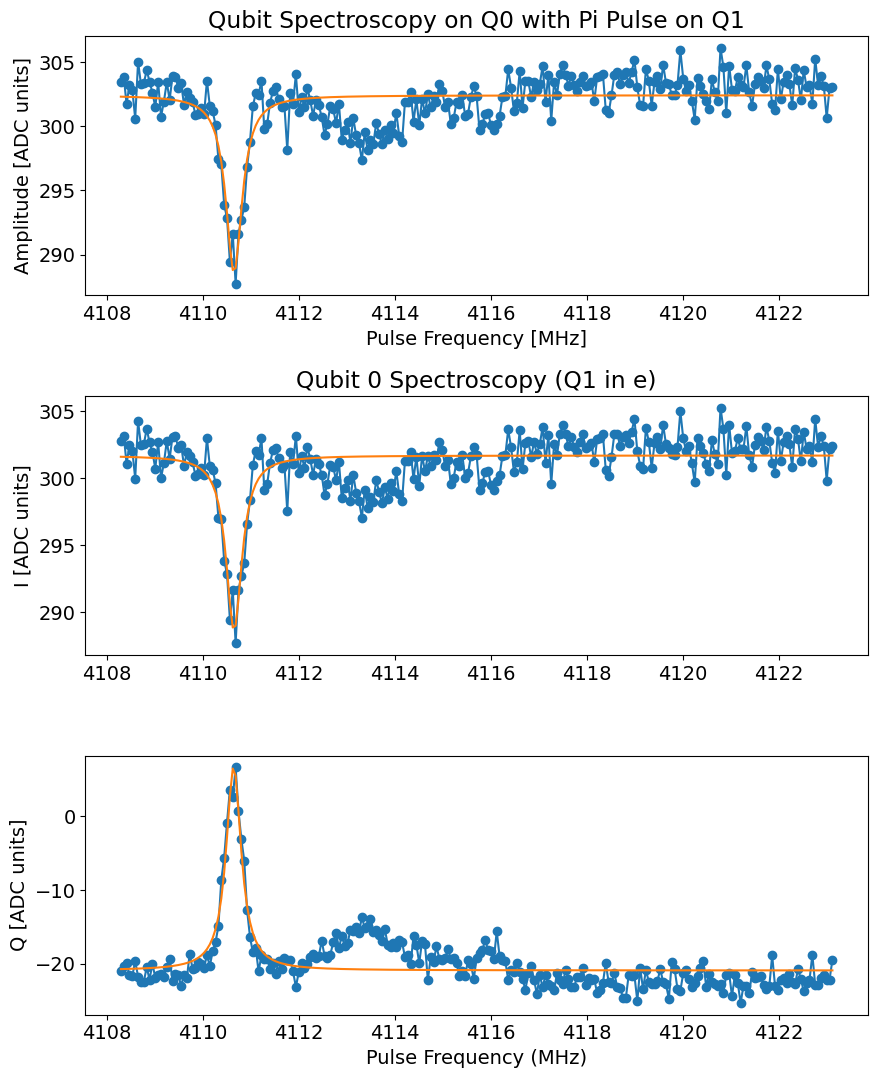

Fit Q0 frequency with ZZ shift [MHz]: 4110.638151152761
Q0 shift due to Q1 in e [MHz]: -5.090972488288571


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4115.820230061448, HWHM 0.23771510367336798
Found peak in I at [MHz] 4115.820851248752, HWHM -0.23039581715789292
Found peak in Q at [MHz] 4115.81604250281, HWHM -0.22676759608731312


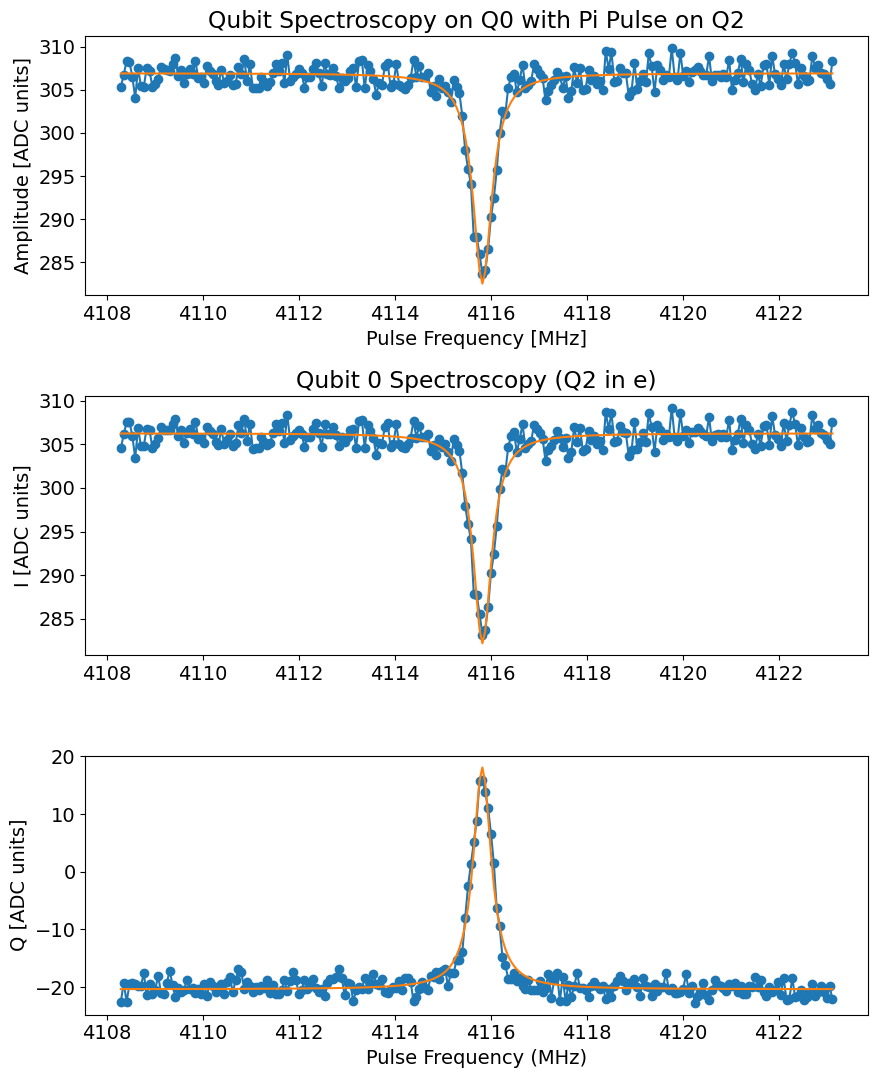

Fit Q0 frequency with ZZ shift [MHz]: 4115.81604250281
Q0 shift due to Q2 in e [MHz]: 0.08691886176075059


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4115.413304051898, HWHM -0.23378498185783636
Found peak in I at [MHz] 4115.412356368978, HWHM -0.2265136515794154
Found peak in Q at [MHz] 4115.416764928537, HWHM 0.23633893554077431


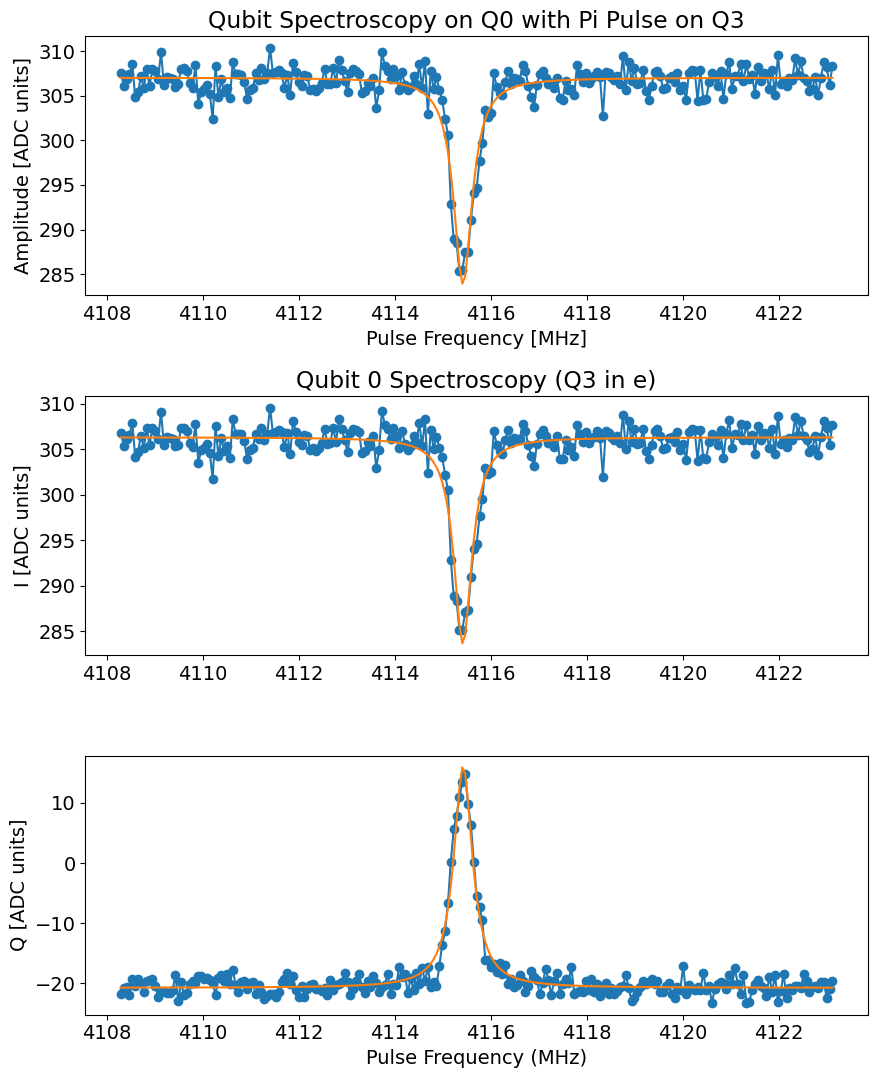

Fit Q0 frequency with ZZ shift [MHz]: 4115.416764928537
Q0 shift due to Q3 in e [MHz]: -0.31235871251192293


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3446.790457304631, HWHM 0.3422377249470363
Found peak in I at [MHz] 3446.808181930503, HWHM 0.33678470727008997
Found peak in Q at [MHz] 3446.8168000136234, HWHM 0.34213192857949515


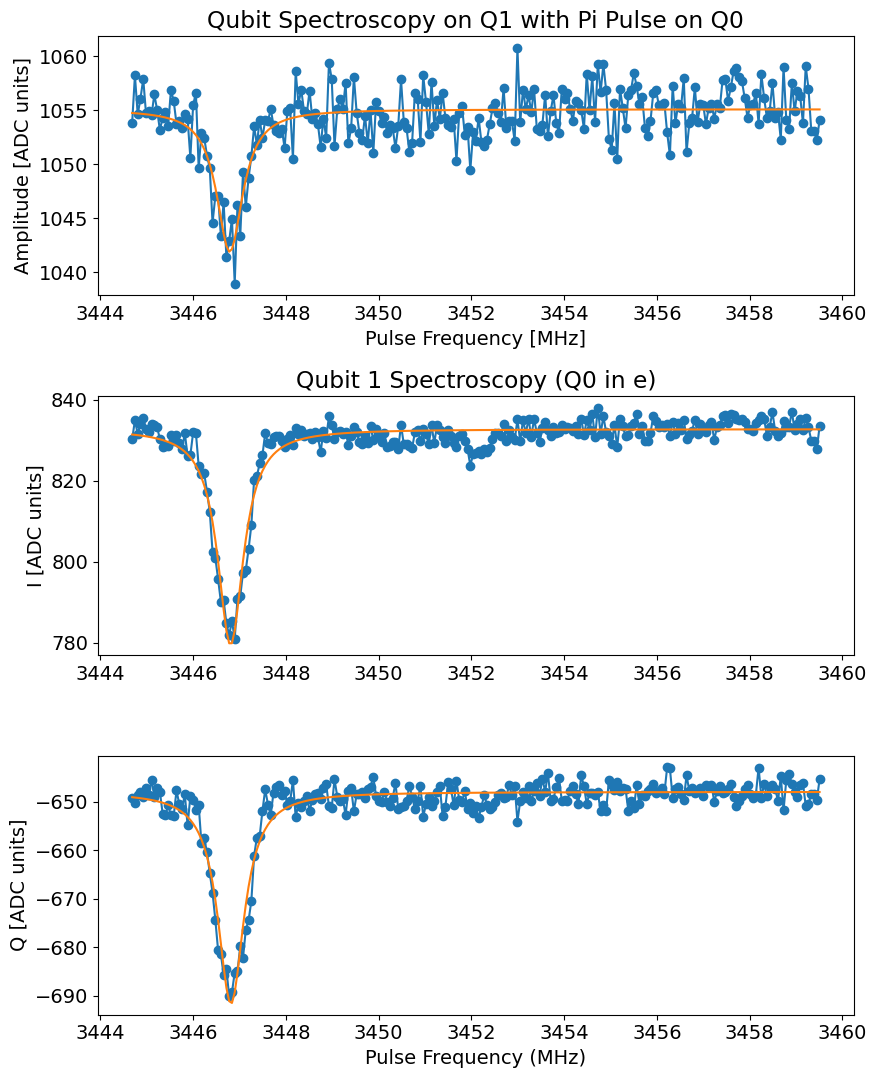

Fit Q1 frequency with ZZ shift [MHz]: 3446.808181930503
Q1 shift due to Q0 in e [MHz]: -5.319042282451392


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3451.0615290256233, HWHM 0.3280277443796446
Found peak in I at [MHz] 3451.07155222938, HWHM 0.2689144124547022
Found peak in Q at [MHz] 3451.077200997385, HWHM -0.2568510641162784


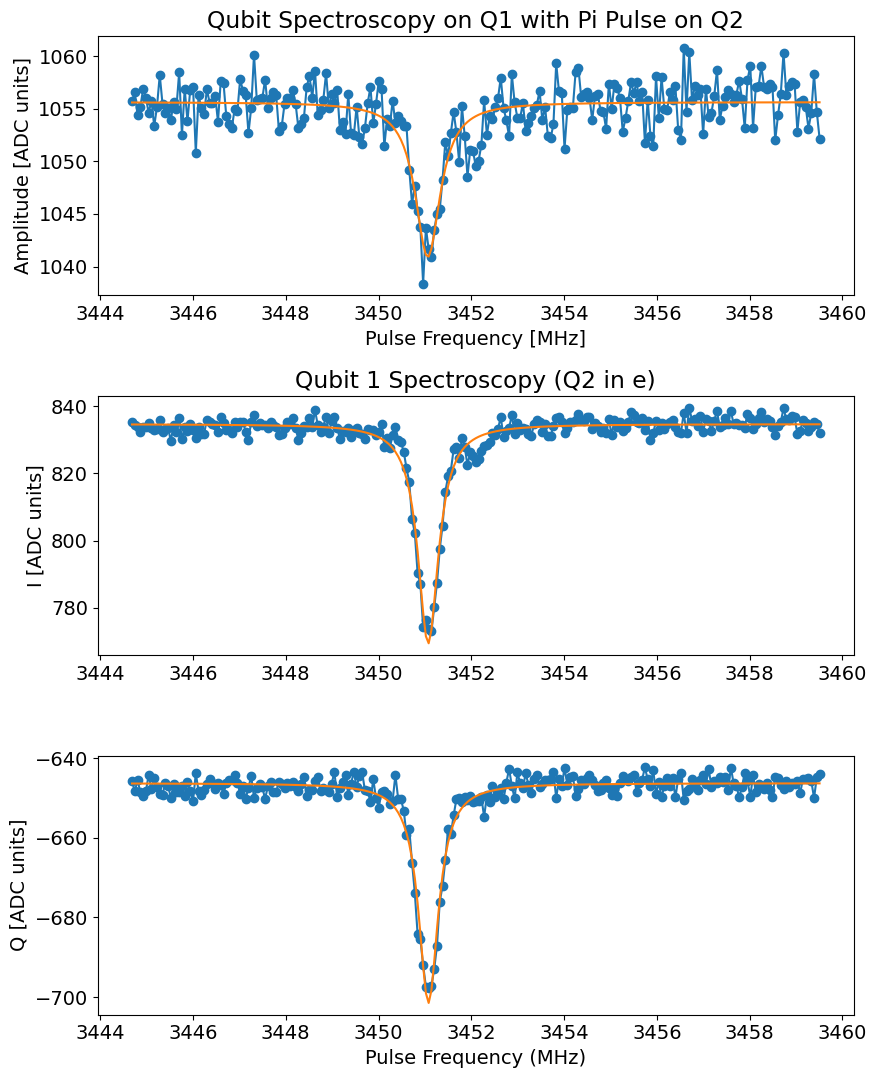

Fit Q1 frequency with ZZ shift [MHz]: 3451.07155222938
Q1 shift due to Q2 in e [MHz]: -1.0556719835744843


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 3450.866681404157, HWHM 0.272029637236877
Found peak in I at [MHz] 3450.877396190614, HWHM -0.25806368632908766
Found peak in Q at [MHz] 3450.8840381365026, HWHM -0.25728515949608105


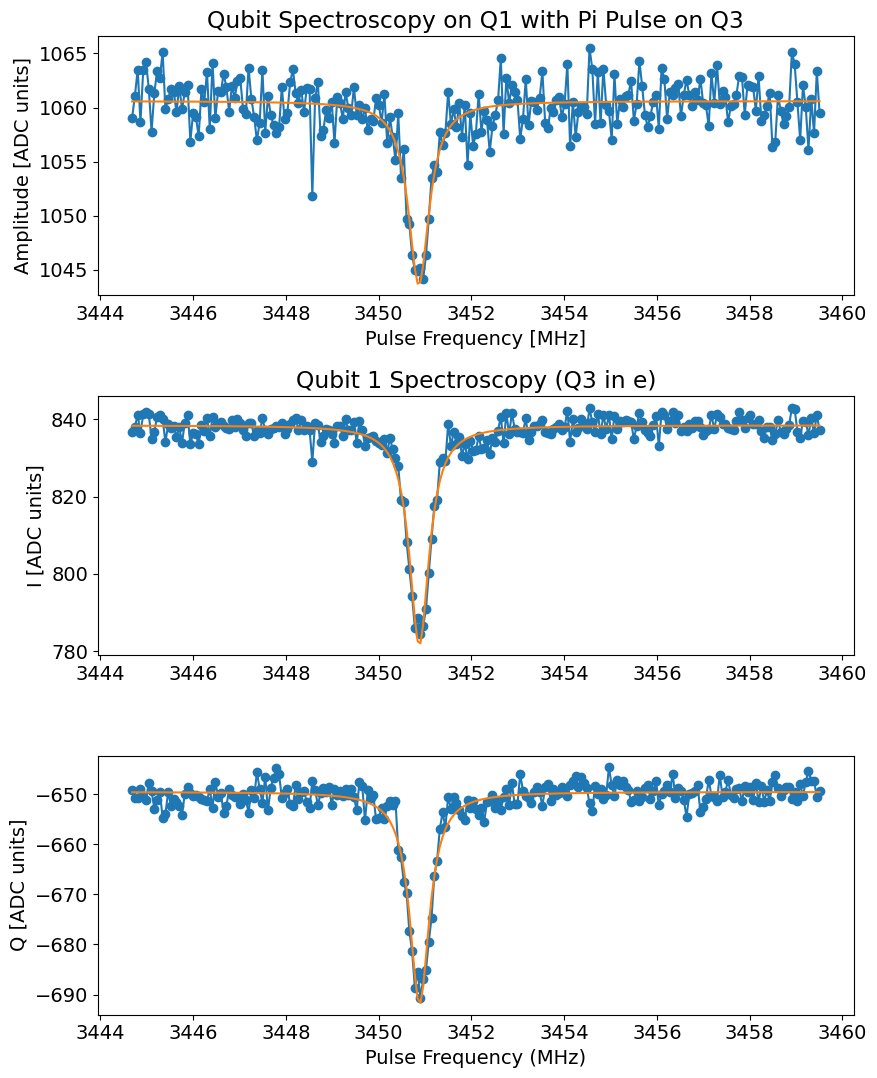

Fit Q1 frequency with ZZ shift [MHz]: 3450.877396190614
Q1 shift due to Q3 in e [MHz]: -1.2498280223403526


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4766.696210703642, HWHM 0.468744783271194
Found peak in I at [MHz] 4766.683688392819, HWHM -0.470570541142828
Found peak in Q at [MHz] 4766.696710099492, HWHM 0.5231818030035714


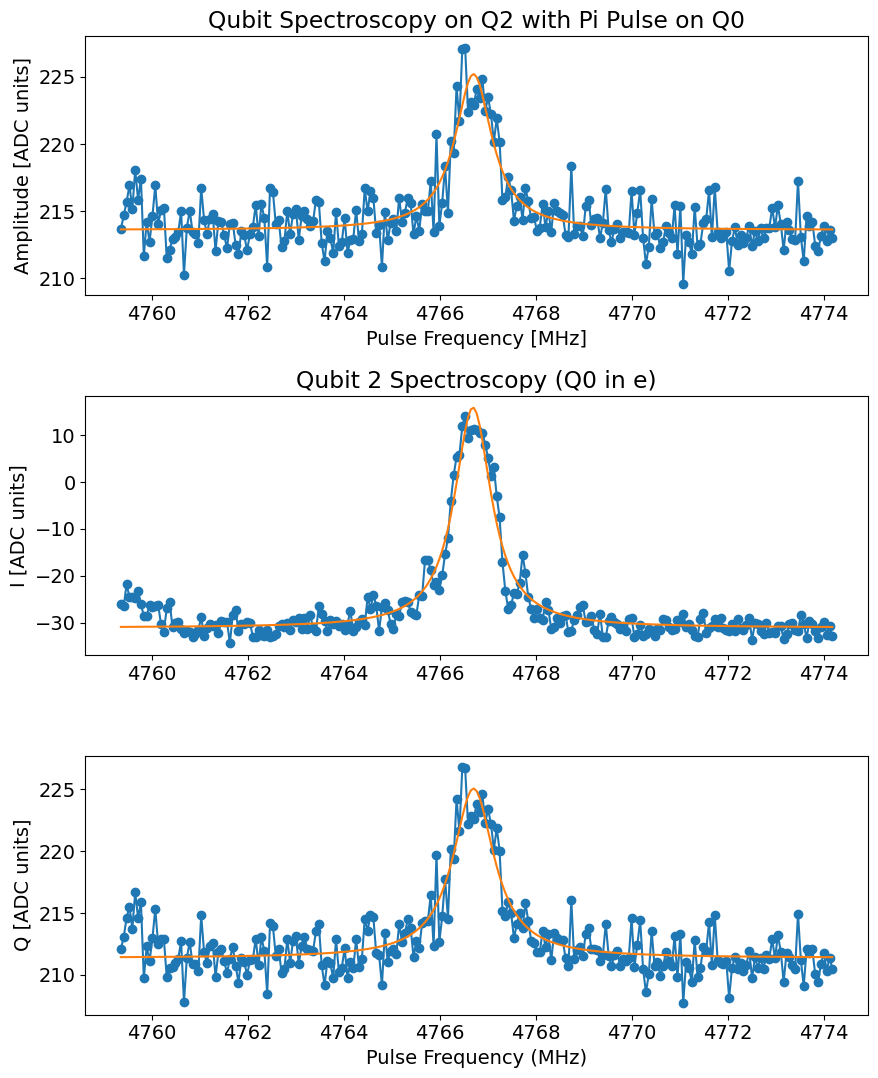

Fit Q2 frequency with ZZ shift [MHz]: 4766.683688392819
Q2 shift due to Q0 in e [MHz]: -0.10732656606069213


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4765.759068665861, HWHM 0.46948027999157027
Found peak in I at [MHz] 4765.760007458304, HWHM 0.5287053860542226
Found peak in Q at [MHz] 4765.767572727118, HWHM 0.5233167386481148


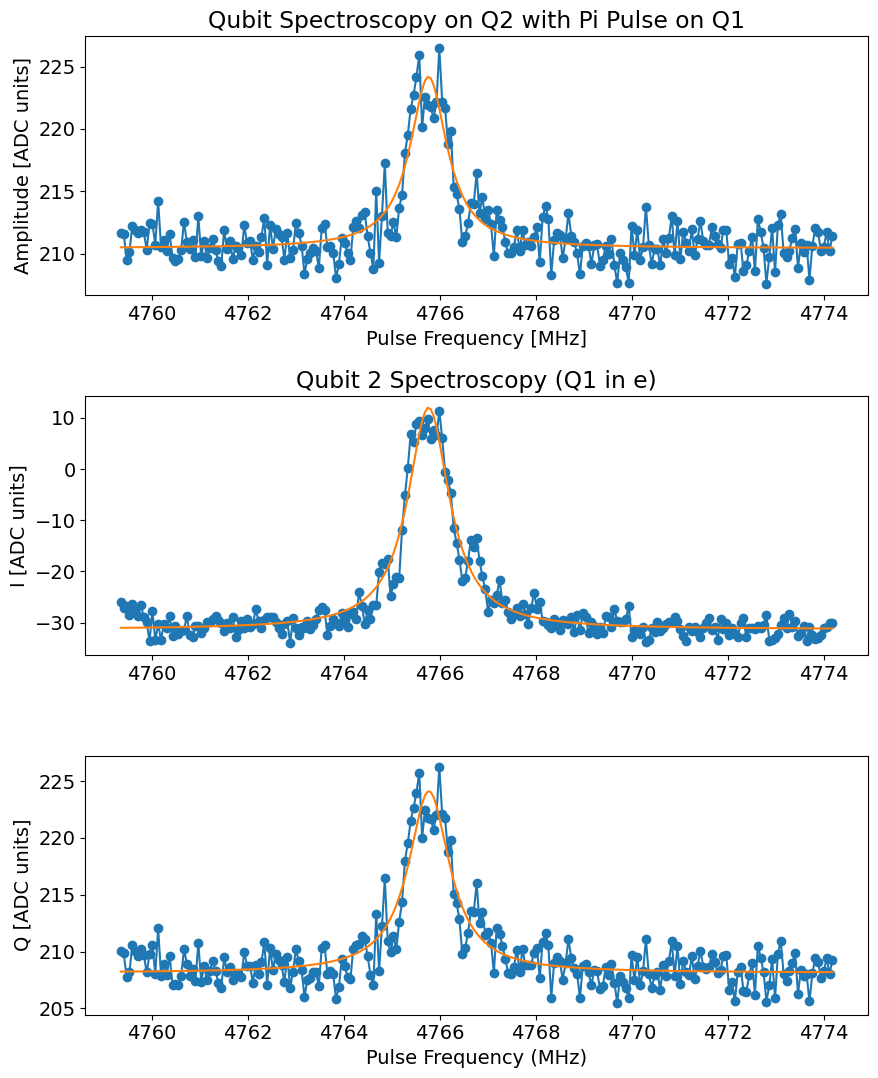

Fit Q2 frequency with ZZ shift [MHz]: 4765.760007458304
Q2 shift due to Q1 in e [MHz]: -1.0310075005754697


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4766.276177441237, HWHM 0.3710860046274713
Found peak in I at [MHz] 4766.3019502297775, HWHM -0.4784625136247632
Found peak in Q at [MHz] 4766.2840670627, HWHM -0.4303487333411894


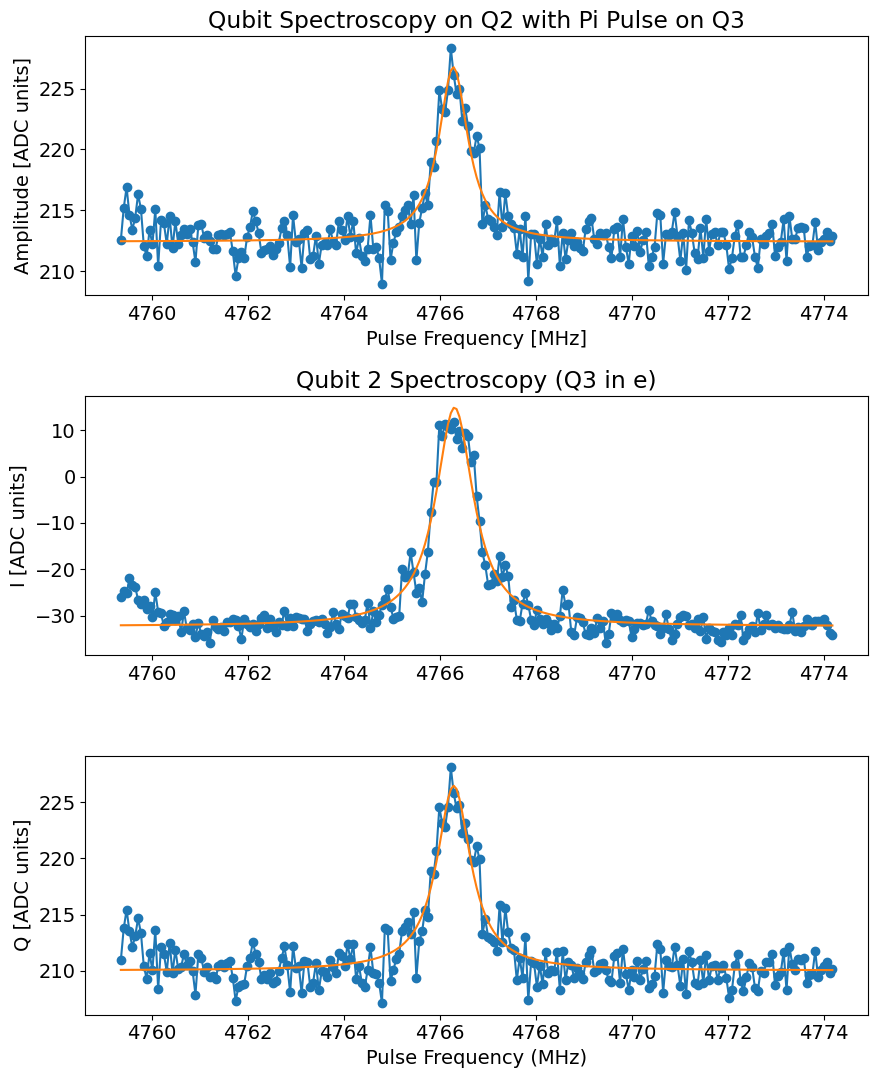

Fit Q2 frequency with ZZ shift [MHz]: 4766.3019502297775
Q2 shift due to Q3 in e [MHz]: -0.48906472910221055


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4385.652518867997, HWHM 0.7891379944323827
Found peak in I at [MHz] 4385.649200524818, HWHM 0.3688840014029667
Found peak in Q at [MHz] 4385.6399524438375, HWHM -0.3549560287012096


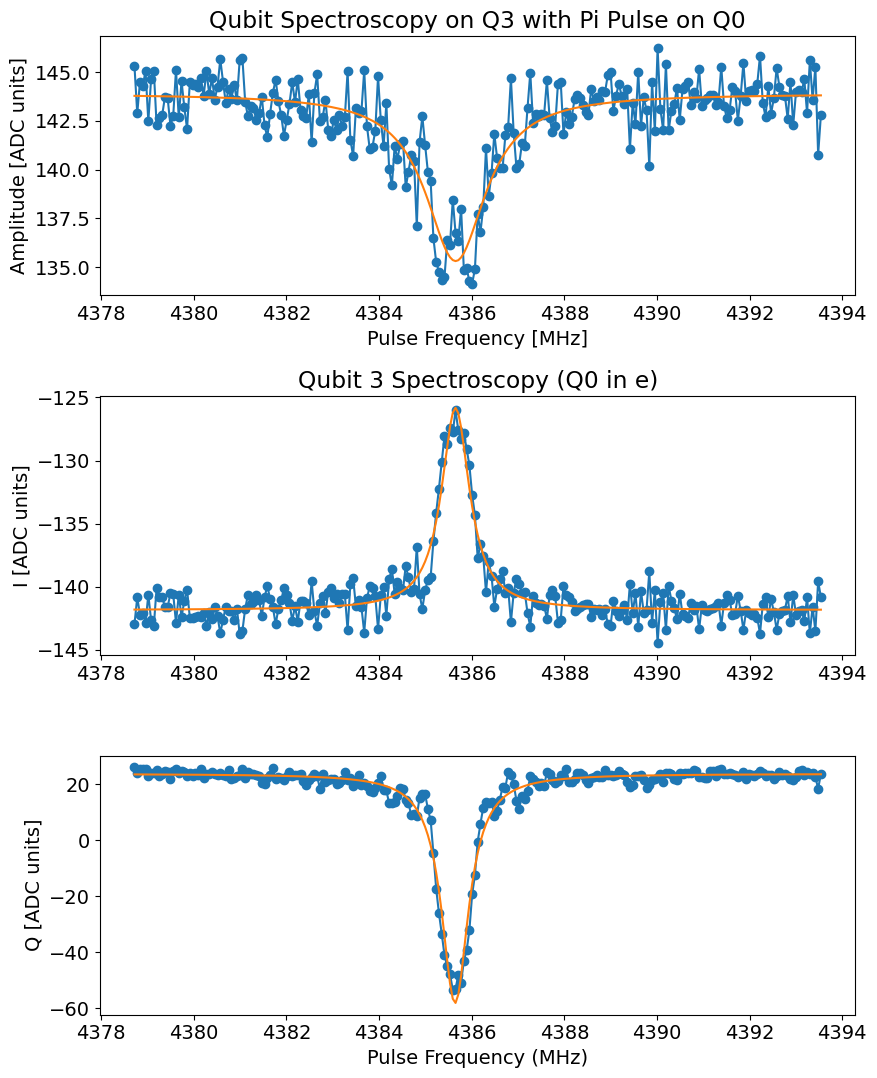

Fit Q3 frequency with ZZ shift [MHz]: 4385.6399524438375
Q3 shift due to Q0 in e [MHz]: -0.5185179285026607


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4384.9368174423635, HWHM 0.9675170568656258
Found peak in I at [MHz] 4384.851090940079, HWHM 0.3530361390531342
Found peak in Q at [MHz] 4384.856579781192, HWHM 0.3507405905439747


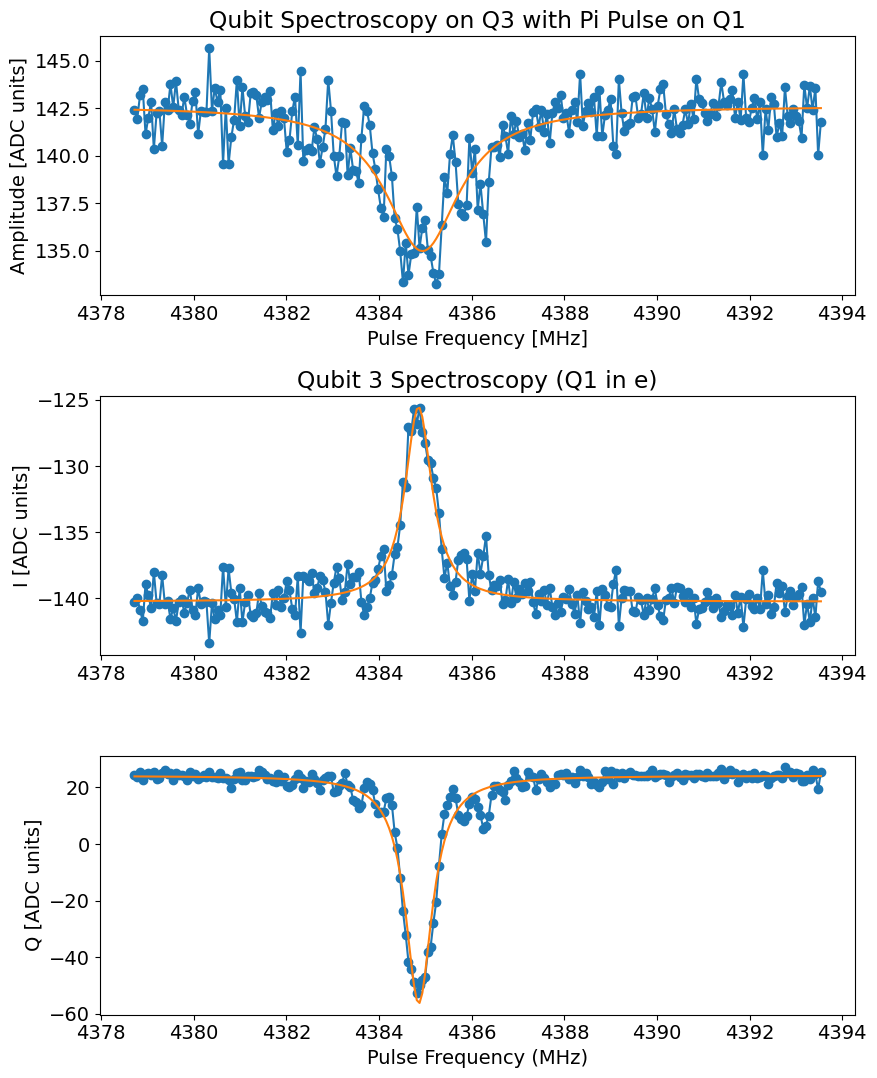

Fit Q3 frequency with ZZ shift [MHz]: 4384.856579781192
Q3 shift due to Q1 in e [MHz]: -1.301890591148549


  0%|          | 0/10 [00:00<?, ?it/s]

Found peak in amps at [MHz] 4385.650788925427, HWHM 0.7675263827161084
Found peak in I at [MHz] 4385.677868625404, HWHM -0.3589852161673012
Found peak in Q at [MHz] 4385.659350555526, HWHM 0.3713760257583192


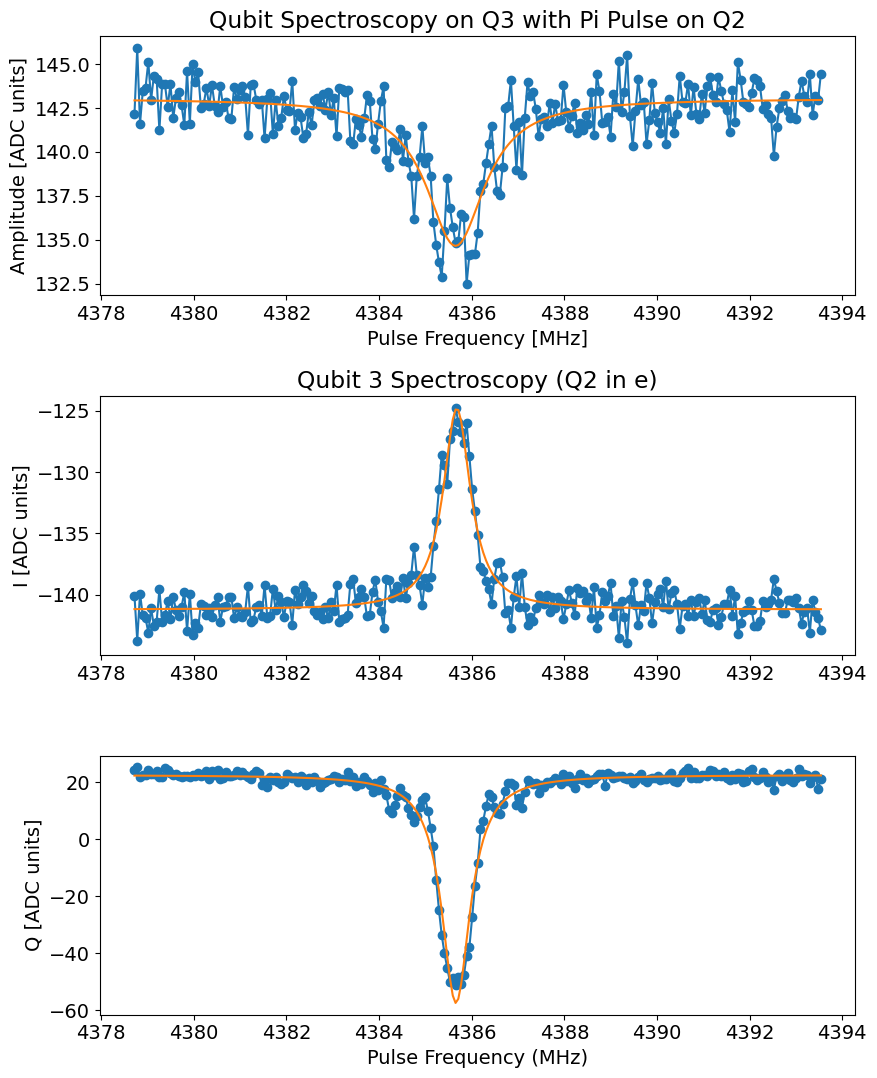

Fit Q3 frequency with ZZ shift [MHz]: 4385.659350555526
Q3 shift due to Q2 in e [MHz]: -0.49911981681452744
[[ 0.         -5.09097249  0.08691886 -0.31235871]
 [-5.31904228  0.         -1.05567198 -1.24982802]
 [-0.10732657 -1.0310075   0.         -0.48906473]
 [-0.51851793 -1.30189059 -0.49911982  0.        ]]


In [10]:
for qubit0 in range(4): # qubit to measure
# for qubit0 in [1]: # qubit to measure
    # for qubit1 in range(2): # qubit to pulse to e
    for qubit1 in range(4): # qubit to pulse to e
    # for qubit1 in range(qubit0+1, 4):
        # if qubit0 != 1: continue # UNCOMMENT IF JUST GETTING FREQS FOR Q1 ZZ
        if qubit1 == qubit0: continue
        qZZspec = meas.PulseProbeCouplingSpectroscopyExperiment(
            soccfg=soc,
            path=expt_path,
            prefix=f"qubit_coupling_spectroscopy_qubit{qubit0}{qubit1}",
            config_file=config_path,
        )
        
        span = 15
        npts = 251
        
        qZZspec.cfg.expt = dict(
            start=qZZspec.cfg.device.qubit.f_ge[qubit0]-span/2, # resonator frequency to be mixed up [MHz]
            # start=3600,
            step=span/npts,
            expts=npts, # Number of experiments stepping from start
            reps=100, # Number of averages per point
            rounds=10, # Number of start to finish sweeps to average over
            pulseB=True, # Whether to apply pi pulse to qubit B
            length=1, # qubit 0 probe constant pulse length [us]
            gain=int(qZZspec.cfg.device.qubit.pulses.pi_ge.gain[qubit0]/5), # pulse gain for qubit we are measuring
            pulse_type='gauss',
            qubits=[qubit0, qubit1],
        )
        
        # qZZspec.cfg.device.readout.relax_delay = [10, 10, 10, 10] # Wait time between experiments [us]
        
        # print(qZZspec.cfg)
        
        qZZspec.go(analyze=False, display=False, progress=True, save=False)

        # ============ POST PROCESSING ============ #
        best_signs = [1, 0, 0]
        best_fit_err_i = np.inf
        best_fit_err_q = np.inf
        for sign in [1, -1]:
            try: 
                qZZspec.analyze(fit=True, signs=[1, sign, sign])
                fit_err_amps = qZZspec.data['fit_err_amps'][2][2]
                fit_err_i = qZZspec.data['fit_err_avgi'][2][2]
                fit_err_q = qZZspec.data['fit_err_avgq'][2][2]
                if fit_err_i < best_fit_err_i:
                    best_signs[1] = sign
                    best_fit_err_i = fit_err_i
                if fit_err_q < best_fit_err_q:
                    best_signs[2] = sign
                    best_fit_err_q = fit_err_q
            except: continue
        if fit_err_amps == np.inf and best_fit_err_i == np.inf and best_fit_err_q == np.inf:
            qZZspec.display(fit=False)
            print(f'WARNING: All fits failed for Q{qubit0} due to Q{qubit1} in e, please manually fix!')
            continue

        qZZspec.analyze(fit=True, signs=best_signs)
        qZZspec.display(fit=True, signs=best_signs)

        qZZspec_fit, qZZspec_fit_err = meas.fitting.get_best_fit(qZZspec.data)
        ZZshifts[qubit0, qubit1] = qZZspec_fit[2] - qZZspec.cfg.device.qubit.f_ge[qubit0]
        print(f'Fit Q{qubit0} frequency with ZZ shift [MHz]: {qZZspec_fit[2]}')
        print(f'Q{qubit0} shift due to Q{qubit1} in e [MHz]: {ZZshifts[qubit0, qubit1]}')
print(ZZshifts)

In [11]:
# ZZshifts[0, 1] = 4125.998679041251 - 4131.202186954483
# ZZshifts[0, 2] = -0.22925396
# ZZshifts[0, 3] = -0.58692004
# ZZshifts[1, 0] = 
# ZZshifts[2, 0] = -0.17297849
# ZZshifts[2, 1] = 4784.023574653984 + 0.15 - 4785.262727180726
# ZZshifts[2, 3] = -0.49538999
# ZZshifts[3, 0] = -0.46704822
# ZZshifts[3, 1] = ZZshifts[1, 3]
# ZZshifts[3, 2] = ZZshifts[2, 3]

ZZshifts = (ZZshifts + ZZshifts.transpose())/2
print(ZZshifts)

[[ 0.         -5.20500739 -0.01020385 -0.41543832]
 [-5.20500739  0.         -1.04333974 -1.27585931]
 [-0.01020385 -1.04333974  0.         -0.49409227]
 [-0.41543832 -1.27585931 -0.49409227  0.        ]]


In [12]:
f_Q1_ZZ = np.array(yaml_cfg.device.qubit.f_Q1_ZZ)
f_ge = np.array(yaml_cfg.device.qubit.f_ge)
# # print(f_Q1_ZZ-f_ge[1])

# ZZshifts[1, :] = f_Q1_ZZ - f_ge[1]
# ZZshifts[:, 1] = f_Q1_ZZ - f_ge[1]
# print(ZZshifts)
print(f_ge[:] + ZZshifts[:, 1])

[4110.52411626 3452.12722421 4765.74767522 4384.88261107]


In [13]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'ZZs: [', end='')
print(*ZZshifts.flatten(), sep=', ', end='')
print(']')

UPDATE MANUALLY IN CONFIG:
ZZs: [0.0, -5.205007385369981, -0.010203852149970771, -0.4154383205072918, -5.205007385369981, 0.0, -1.043339742074977, -1.2758593067444508, -0.010203852149970771, -1.043339742074977, 0.0, -0.494092272958369, -0.4154383205072918, -1.2758593067444508, -0.494092272958369, 0.0]


In [18]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q1_ZZ: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[1]).flatten(), sep=', ', end=']\n')
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[:,1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q1_ZZ: [3447.059927670812, 3452.4637168981253, 3451.3549570752098, 3451.3029930432813]
f_Q_ZZ1: [4110.402451835484, 3452.4637168981253, 4765.712058232431, 4384.955030023174]


# Get couplings by optimization

In [19]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from scipy.optimize import minimize

In [20]:
# ZZshifts = np.array([[ 0., -0.6, -0.06, 0.12],
#  [-0.5, 0., -4.3, -0.86],
#  [ -0.04, -5.0,  0., -0.21 ],
#  [ -0.25, -0.44, 0.11, 0.]]
# )

In [21]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_diff(gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=qubit_freqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    return np.sum(np.abs(1e3*(abs(ZZ_matrix) - abs(qram.get_ZZ_matrix())))**2)

In [22]:
x0 = np.array([50, 50, 50, 5, 5, 5])
qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)
bounds = [(1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)]

result = minimize(ZZ_g_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts), bounds=bounds, method='L-BFGS-B')

qubit freqs [4115.62905969 3452.4637169  4766.82081806 4386.20844475]
alphas [-227.97717939  -97.32501165 -189.75583687 -172.94409802]


In [23]:
print(f'Success: {result.success}')
gs_opt = result.x # GHz
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]')
print('gs: [', end='')
print(*(gs_opt*1e3), sep=', ', end=']\n')

print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=1e-3*qubit_freqs_MHz,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured ZZ matrix [MHz]')
print(ZZshifts)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print(f'Optimization error: {ZZ_g_diff(gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts)}')

Success: True
Optimized g01, g12, g13, g02, g03, g23 [MHz]
gs: [53.86111790753793, 55.951615253475715, 42.896055738679614, 1.2556674383426387, 2.535432566502201, 6.608656393450753]
ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.22660786 -0.05099604 -0.44819074]
 [-5.40378923  0.         -1.10875982 -1.16072385]
 [-0.05099604 -1.10875982  0.         -0.55422958]
 [-0.63285761 -1.25341473 -0.55422958  0.        ]]
Optimized ZZ matrix [MHz]
[[0.         5.31520053 0.0510044  0.54051826]
 [5.31520053 0.         1.10875989 1.20706441]
 [0.0510044  1.10875989 0.         0.55423237]
 [0.54051826 1.20706441 0.55423237 0.        ]]
Optimization error: 0.03704334575230949


# ZZ shifted pi pulse calibrations for Q1

In [10]:
save_data = False
saved_files = []

In [11]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [12]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q1_ZZ=[0]*4,
    )

######### BEGINNING QUBIT 2 #########
q0 is 2 pi_len is 0.015
-------- Amp rabi --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 20702
	Pi/2 gain from amps data [dac units]: 10351
Pi gain from avgi data [dac units]: 11094
	Pi/2 gain from avgi data [dac units]: 5547
Pi gain from avgq data [dac units]: 11066
	Pi/2 gain from avgq data [dac units]: 5533


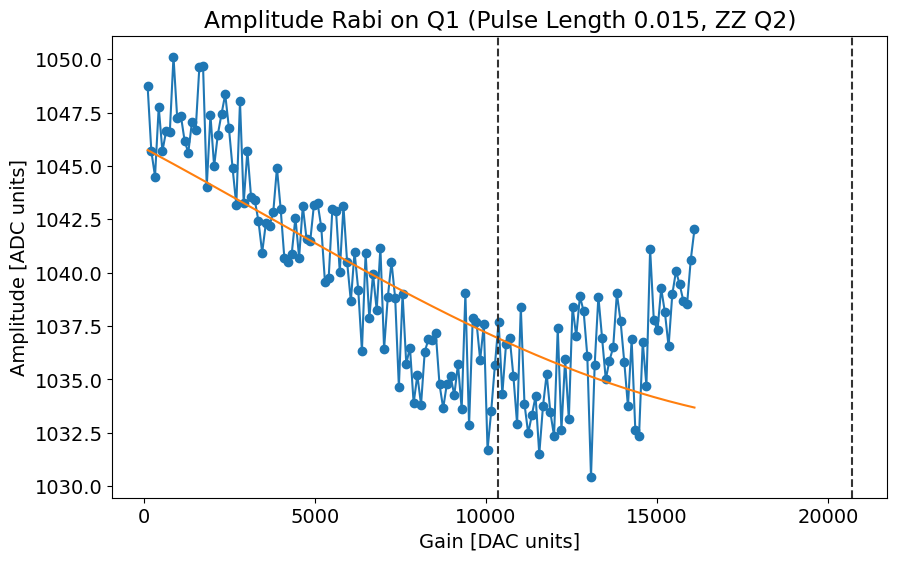

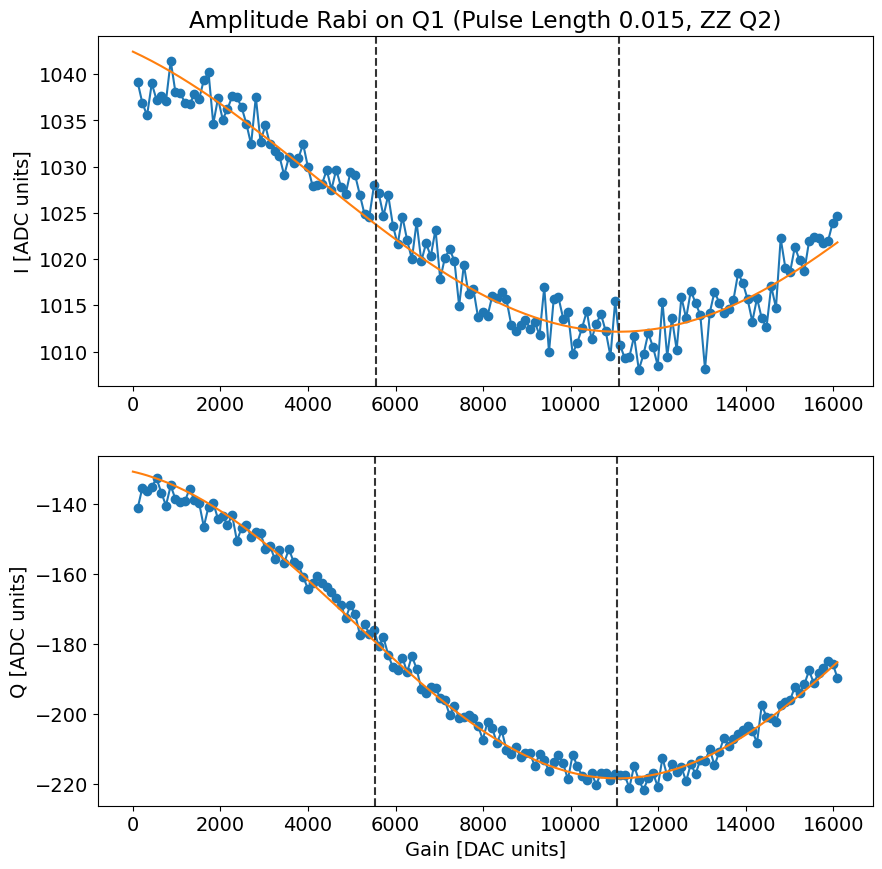

*Set Q1 pi pulse sigma with Q2 in e to 0.015*
*Set Q1 pi pulse gain with Q2 in e to 11066*
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 3451.327108416351
Fit frequency from amps [MHz]: 2.260866378057885 +/- 0.014137150018818571
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3451.0662420382932
 	3447.0662420382932
T2 Ramsey from fit amps [us]: 1.5805564643932513
Current pi pulse frequency: 3451.327108416351
Fit frequency from I [MHz]: 2.2515520617466045 +/- 0.007499427008869411
Suggested new pi pulse frequency from fit I [MHz]:
 	3451.0755563546045
 	3447.0755563546045
T2 Ramsey from fit I [us]: 1.8490451398456198
Fit frequency from Q [MHz]: 2.2449909279725246 +/- 0.004607594597757388
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3451.0821174883786
 	3447.0821174883786
T2 Ramsey from fit Q [us]: 1.9784334922552413


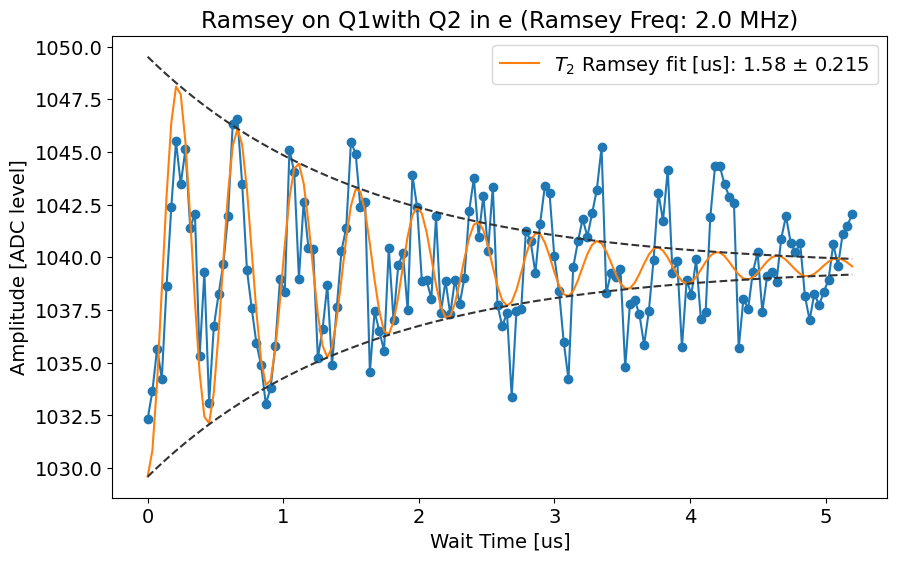

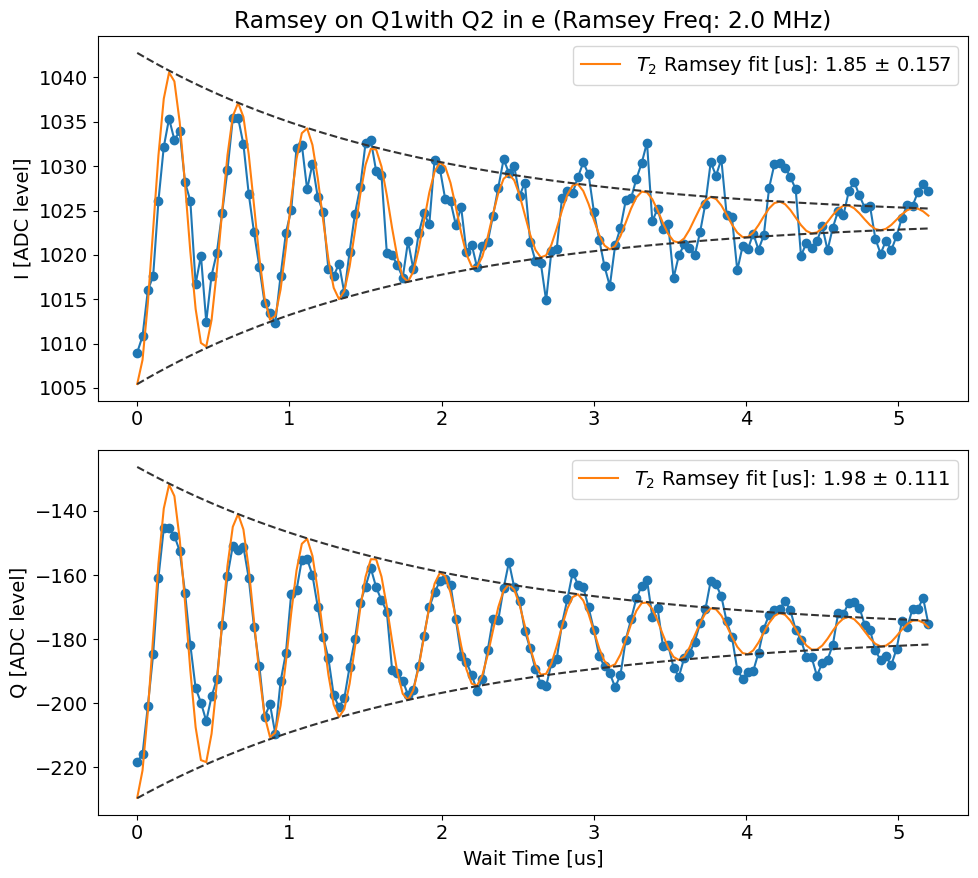

*Set Q1 pi pulse freq with Q2 in e to 3451.0821174883786*
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 11324
	Pi/2 gain from amps data [dac units]: 5662
Pi gain from avgi data [dac units]: 11107
	Pi/2 gain from avgi data [dac units]: 5553
Pi gain from avgq data [dac units]: 11005
	Pi/2 gain from avgq data [dac units]: 5502


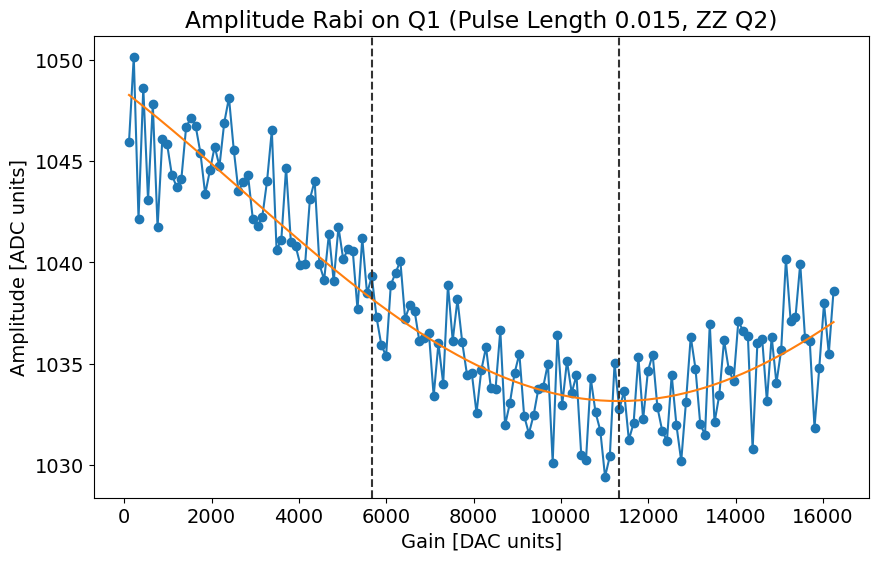

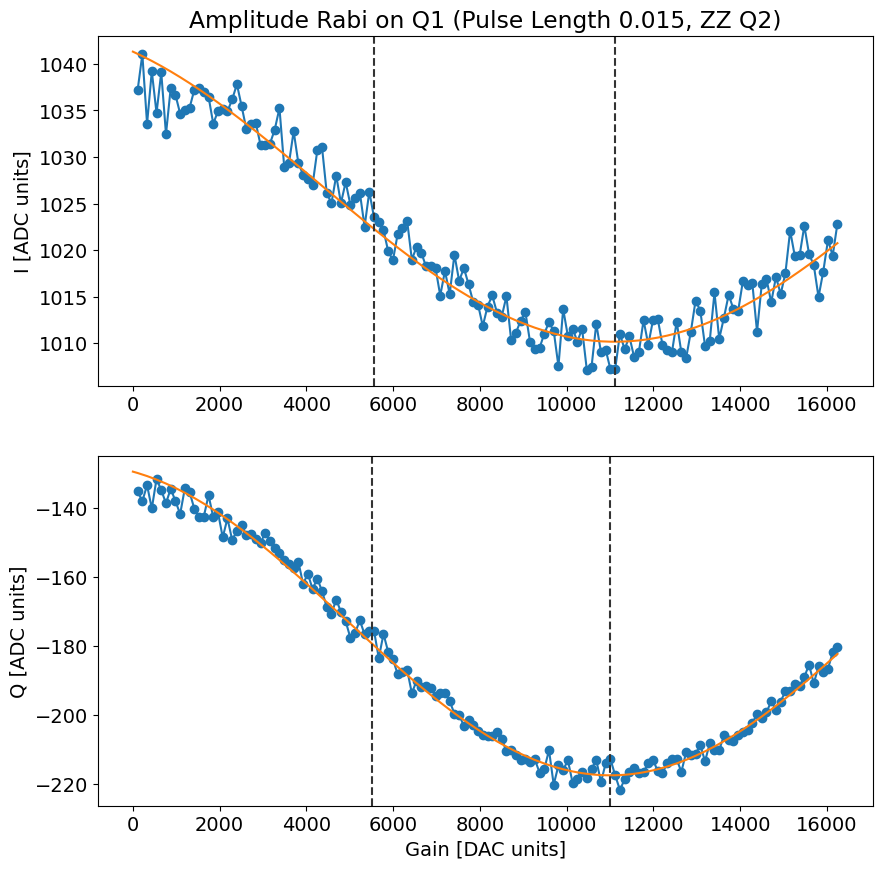

*Set Q1 pi pulse sigma with Q2 in e pi_Q1_ZZ[2] to 0.015*
*Set Q1 pi pulse gain with Q2 in e pi_Q1_ZZ[2] to 11005*



######### BEGINNING QUBIT 3 #########
q0 is 3 pi_len is 0.015
-------- Amp rabi --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 11239
	Pi/2 gain from amps data [dac units]: 5619
Pi gain from avgi data [dac units]: 11063
	Pi/2 gain from avgi data [dac units]: 5531
Pi gain from avgq data [dac units]: 10950
	Pi/2 gain from avgq data [dac units]: 5475


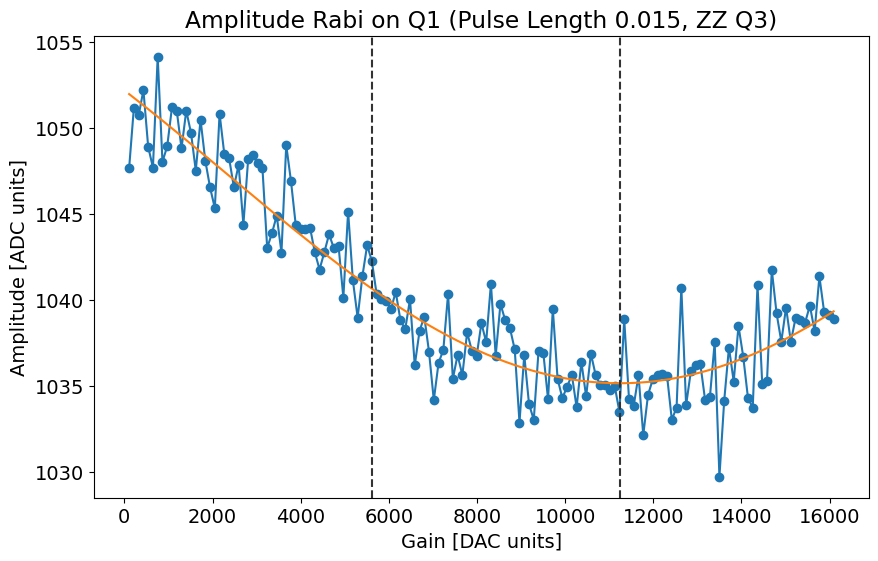

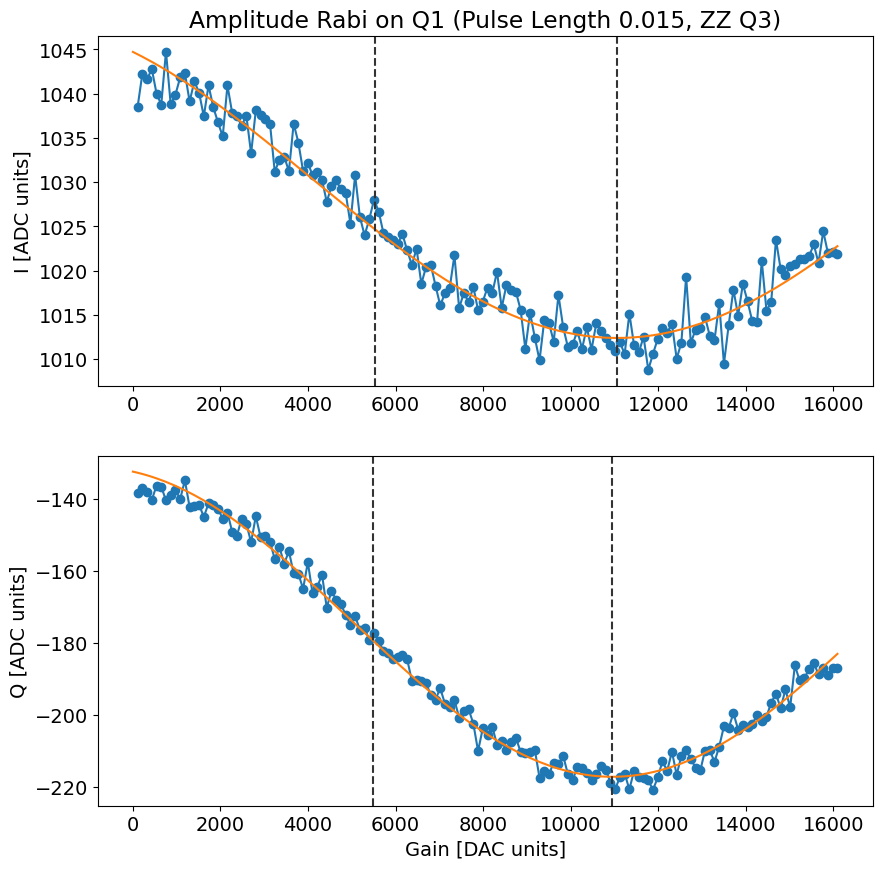

*Set Q1 pi pulse sigma with Q3 in e to 0.015*
*Set Q1 pi pulse gain with Q3 in e to 10950*
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 3451.125854046987
Fit frequency from amps [MHz]: 2.265945428062584 +/- 0.008009809347421768
Suggested new pi pulse frequencies from fit amps [MHz]:
 	3450.8599086189247
 	3446.8599086189247
T2 Ramsey from fit amps [us]: 2.206891241101656
Current pi pulse frequency: 3451.125854046987
Fit frequency from I [MHz]: 2.2582463562758806 +/- 0.005118144771836455
Suggested new pi pulse frequency from fit I [MHz]:
 	3450.8676076907113
 	3446.8676076907113
T2 Ramsey from fit I [us]: 2.421659429588453
Fit frequency from Q [MHz]: 2.2499221333235004 +/- 0.004091524658037258
Suggested new pi pulse frequencies from fit Q [MHz]:
 	3450.8759319136634
 	3446.8759319136634
T2 Ramsey from fit Q [us]: 2.2779809666224073


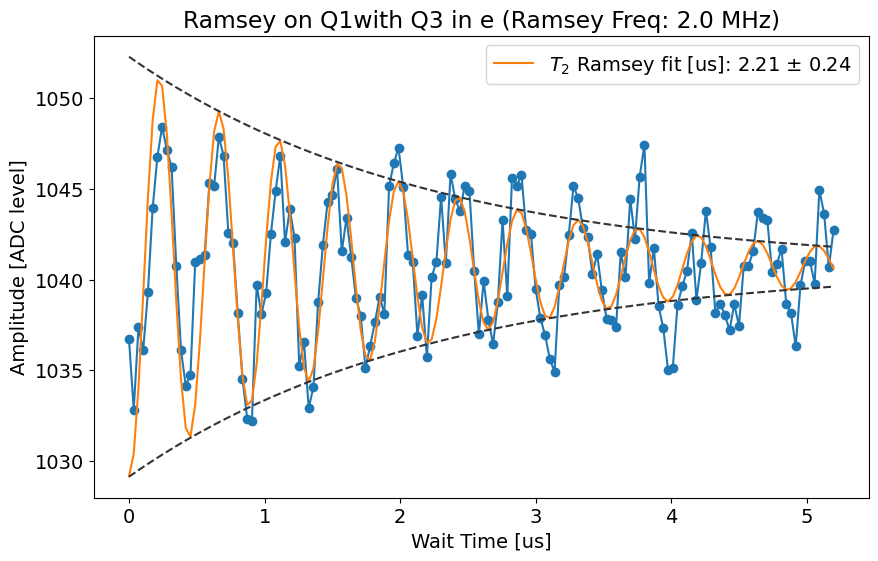

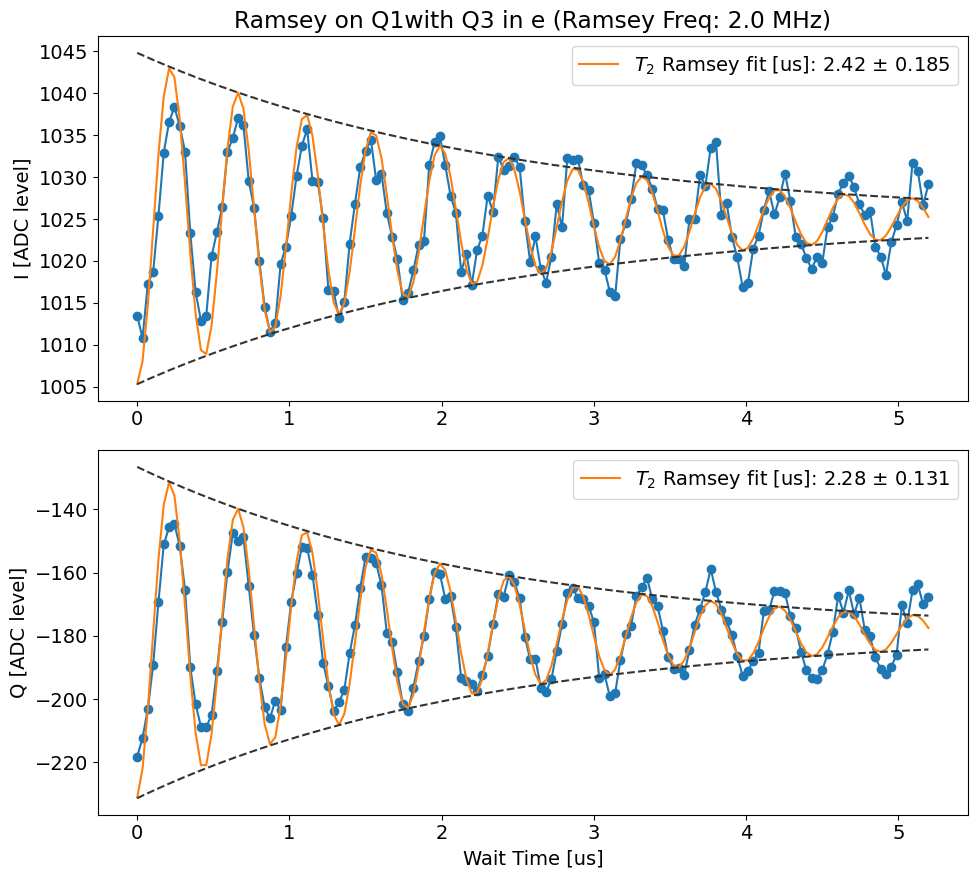

*Set Q1 pi pulse freq with Q3 in e to 3450.8759319136634*
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 11217
	Pi/2 gain from amps data [dac units]: 5608
Pi gain from avgi data [dac units]: 11011
	Pi/2 gain from avgi data [dac units]: 5505
Pi gain from avgq data [dac units]: 10895
	Pi/2 gain from avgq data [dac units]: 5447


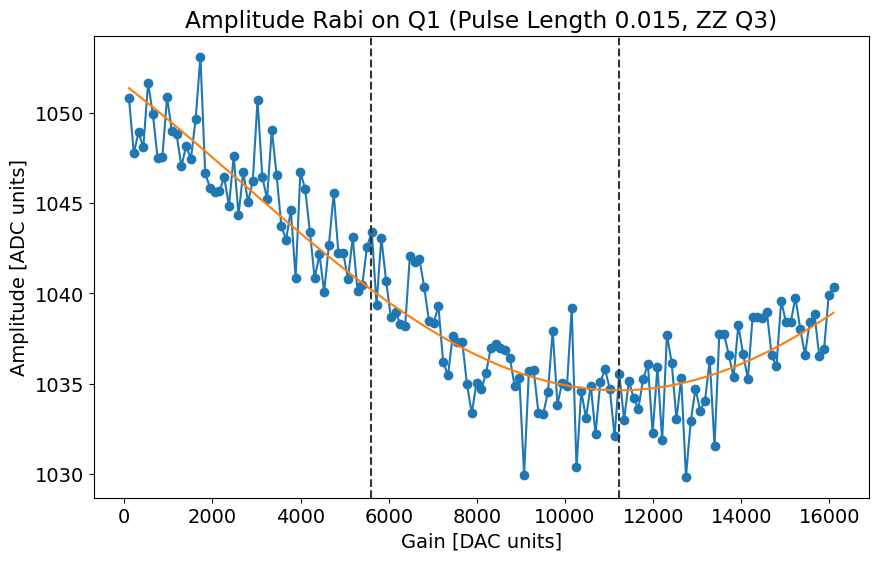

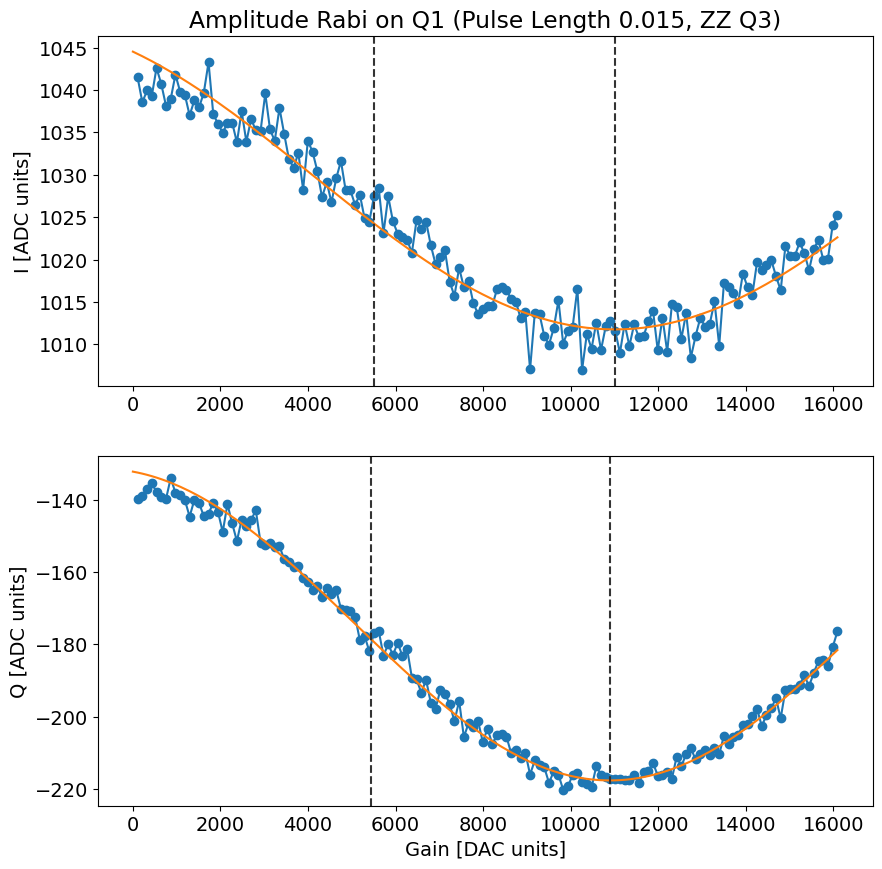

*Set Q1 pi pulse sigma with Q3 in e pi_Q1_ZZ[3] to 0.015*
*Set Q1 pi pulse gain with Q3 in e pi_Q1_ZZ[3] to 10895*





In [15]:
try: save_data
except:
    assert False, 'you did not run the cell above!'
q1 = 1
# for q0 in [0]:
for q0 in range(4):
    if q0 == q1: continue

    print(f"######### BEGINNING QUBIT {q0} #########")

    # print(f"-------- length rabi --------")
    # lengthrabiZZ = meas.LengthRabiExperiment(
    #     soccfg=soc,
    #     path=expt_path,
    #     prefix=f"length_rabi_ZZ_qubit{q0}{q1}",
    #     config_file=config_path,
    # )
    # lengthrabiZZ.cfg = AttrDict(deepcopy(yaml_cfg))

    # lengthrabiZZ.cfg.expt = dict(
    #     start=0, # pulse length (sigma) [us]
    #     step=soc.cycles2us(1), # [us]
    #     expts=101,
    #     reps=2000,
    #     gain=yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0],
    #     pulse_type='gauss',
    #     qubits=[q0, q1],
    #     checkZZ=True,
    #     checkEF=False, 
    # )

    # try:
    #     import Pyro4.util
    #     try:
    #         lengthrabiZZ.go(analyze=False, display=False, progress=True, save=False)
    #     except Exception:
    #         print("Pyro traceback:")
    #         print("".join(Pyro4.util.getPyroTraceback()))

    #     lengthrabiZZ.analyze(fit=True)
    
    #     lengthrabi_fit, lengthrabi_fit_err = meas.fitting.get_best_fit(lengthrabiZZ.data)
    
    #     lengthrabiZZ.display(fit=True)
    #     p = lengthrabi_fit
    #     if p[2] > 180: p[2] = p[2] - 360
    #     elif p[2] < -180: p[2] = p[2] + 360
    #     if p[2] < 0: pi_len = (1/2 - p[2]/180)/2/p[1]
    #     else: pi_len = (3/2 - p[2]/180)/2/p[1]
    #     pi_len = np.max((0.9*pi_len, 0.015)) # since we run the length rabi at a < max gain
    
    #     lengthrabi_decay = p[3]

    #     print(f'Will use sigma {pi_len} for amplitude rabi')

    #     if save_data: saved_files.append(lengthrabiZZ.save_data())

    # except Exception as e:
    #     print(e)
    #     print(f'!!!!!!! LENGTH RABI FAILED ON QUBIT {q0} !!!!!!!')
    #     continue
    
    pi_len = yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]
    print('q0 is', q0, 'pi_len is', pi_len)

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=80,
        rounds=10,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q1}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2.0, # [MHz]
        reps=80,
        rounds=10,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, q1],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q1_ZZ[q0] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q1_ZZ[q0] = new_pi_freq
        print(f'*Set Q1 pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q1_ZZ[q0]}*')
        results['f_Q1_ZZ'][q0] =  new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {q0}!!!!!!!')
        continue


    print(f"-------- Amp rabi round 2 --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{q1}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=80,
        rounds=10,
        sigma_test=pi_len, # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, q1],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)
        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = amprabi.cfg.expt.sigma_test

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0] = pi_len
        results['sigma'][q0] =  pi_len
        print(f'*Set Q1 pi pulse sigma with Q{q0} in e pi_Q1_ZZ[{q0}] to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.sigma[q0]}*')

        yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0] = int(pi_gain)
        results['gain'][q0] =  int(pi_gain)
        print(f'*Set Q1 pi pulse gain with Q{q0} in e pi_Q1_ZZ[{q0}] to {yaml_cfg.device.qubit.pulses.pi_Q1_ZZ.gain[q0]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {q0} !!!!!!!')
        continue

    
    print("\n\n")

In [16]:
print('pi_Q1_ZZ')
print(results)
for saved_file in saved_files:
    print(saved_file)

pi_Q1_ZZ
{'gain': [11514, 0, 11005, 10895], 'sigma': [0.015, 0, 0.015, 0.015], 'f_Q1_ZZ': [3446.870091628903, 0, 3451.0821174883786, 3450.8759319136634]}


# ZZ shifted pi pulse calibrations for starting Q1 in e (pi_Q_ZZ1)

In [34]:
print("UPDATE MANUALLY IN CONFIG:")
print(f'f_Q_ZZ1: [', end='')
print(*(ZZshifts[1] + yaml_cfg.device.qubit.f_ge[:]).flatten(), sep=', ', end=']\n')

UPDATE MANUALLY IN CONFIG:
f_Q_ZZ1: [4110.225270463936, 3452.4637168981253, 4765.712058232431, 4385.047720896367]


In [17]:
save_data = True
saved_files = []

In [18]:
import yaml
with open(config_file, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

In [19]:
results = dict(
    gain=[0]*4,
    sigma=[0]*4,
    f_Q_ZZ1=[0]*4,
    )

-------- Amp rabi --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 28123
	Pi/2 gain from amps data [dac units]: 14061
Pi gain from avgi data [dac units]: 28499
	Pi/2 gain from avgi data [dac units]: 14249
Pi gain from avgq data [dac units]: 80946
	Pi/2 gain from avgq data [dac units]: 40473


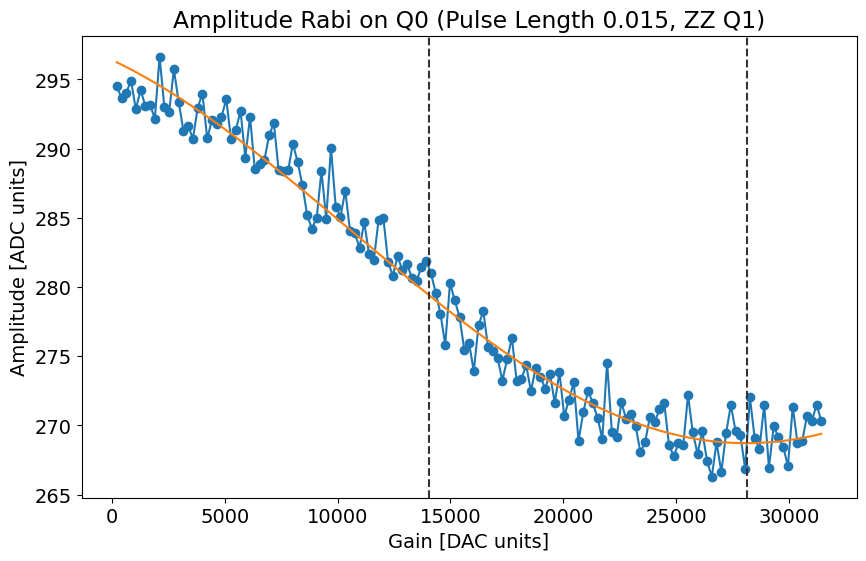

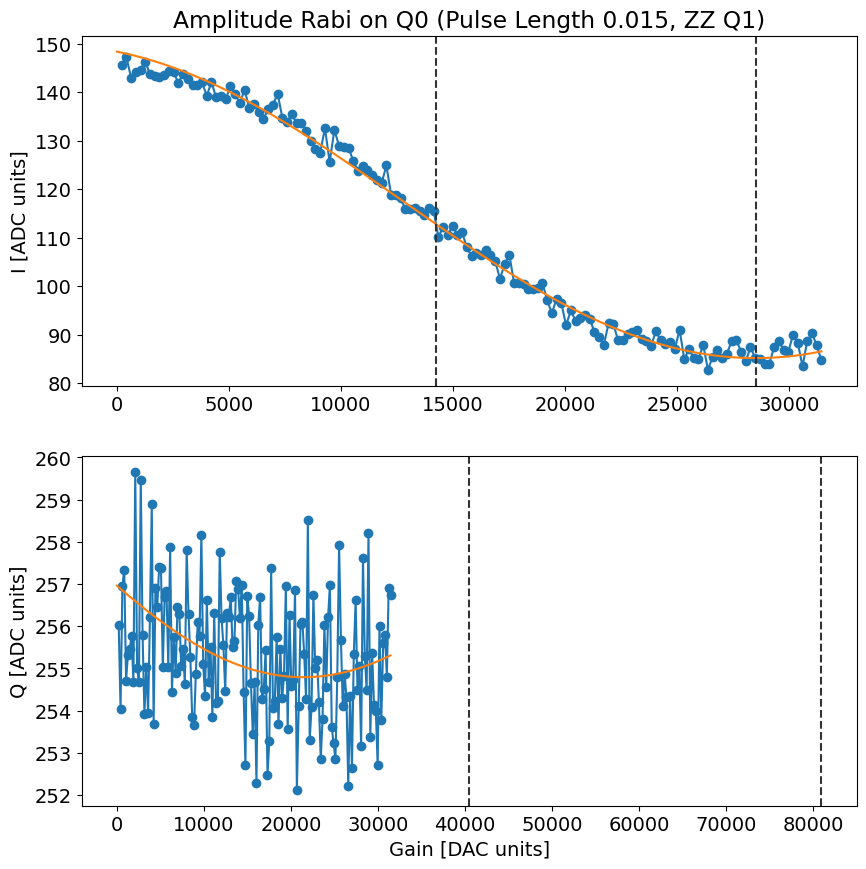

*Set Q0 pi pulse gain with Q1 in e to 28499*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_amp_rabi_qubit10.h5
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 4110.422031286086
Fit frequency from amps [MHz]: 1.7706999391655445 +/- 0.0046927517911336
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4110.65133134692
 	4106.65133134692
T2 Ramsey from fit amps [us]: 3.8758296921588817
Current pi pulse frequency: 4110.422031286086
Fit frequency from I [MHz]: 1.7692332599145113 +/- 0.005004068023958903
Suggested new pi pulse frequency from fit I [MHz]:
 	4110.652798026172
 	4106.652798026172
T2 Ramsey from fit I [us]: 3.0477029607334694
Fit frequency from Q [MHz]: 1.6624150857803905 +/- 0.03445868296443866
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4110.759616200306
 	4106.759616200306
T2 Ramsey from fit Q [us]: 1.039341517857143


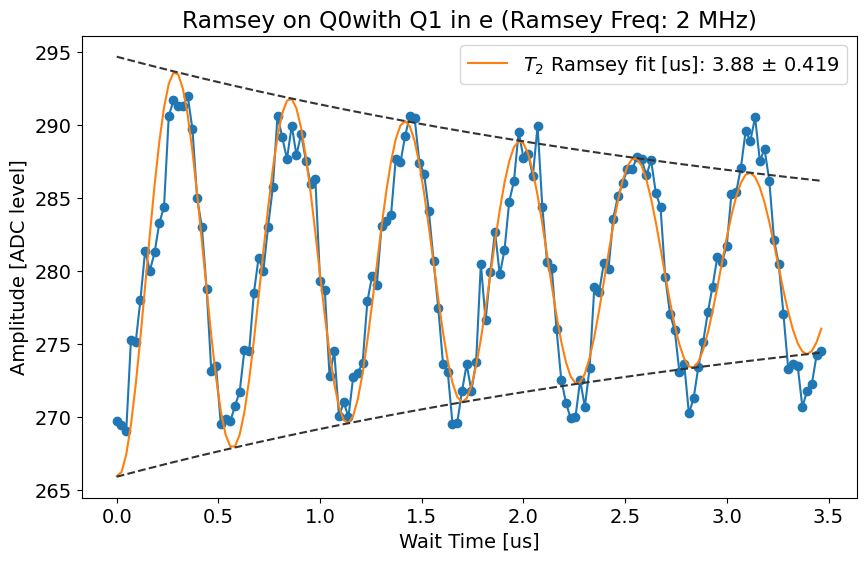

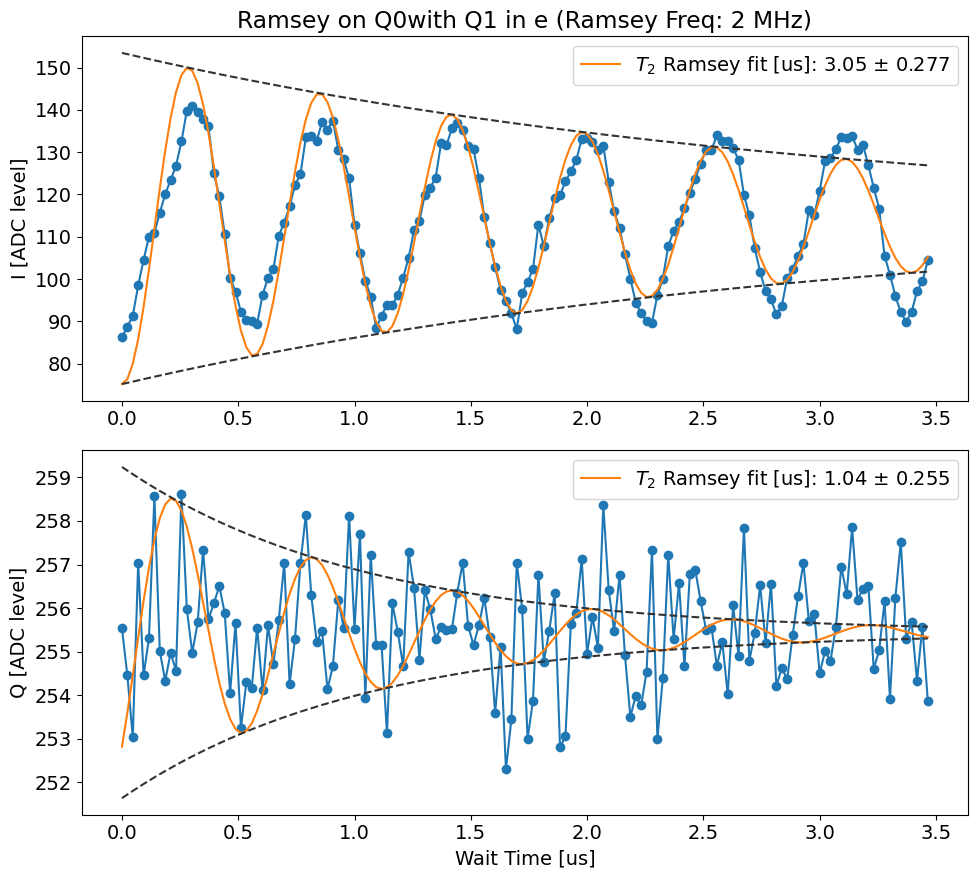

*Set Q0 pi pulse freq with Q1 in e to 4110.652798026172*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramsey_qubit10.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 27718
	Pi/2 gain from amps data [dac units]: 13859
Pi gain from avgi data [dac units]: 28054
	Pi/2 gain from avgi data [dac units]: 14027
Pi gain from avgq data [dac units]: 84287
	Pi/2 gain from avgq data [dac units]: 42143


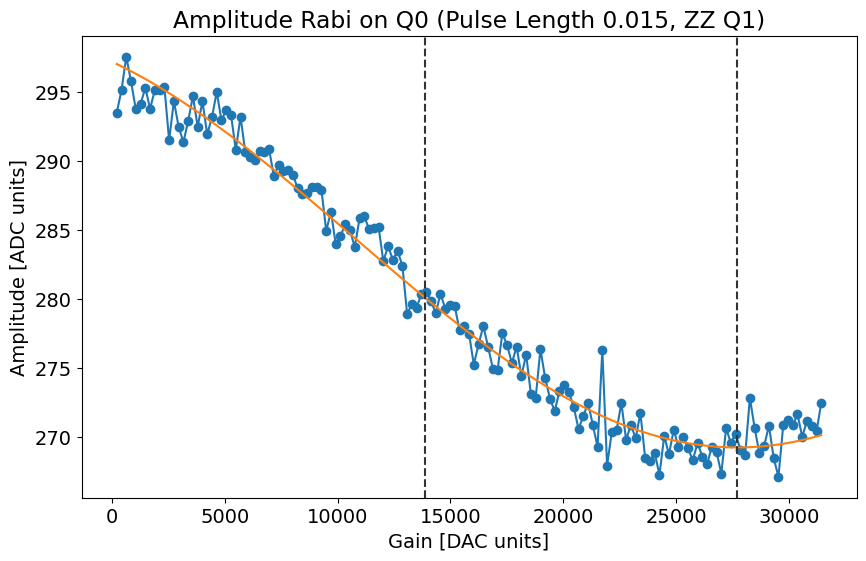

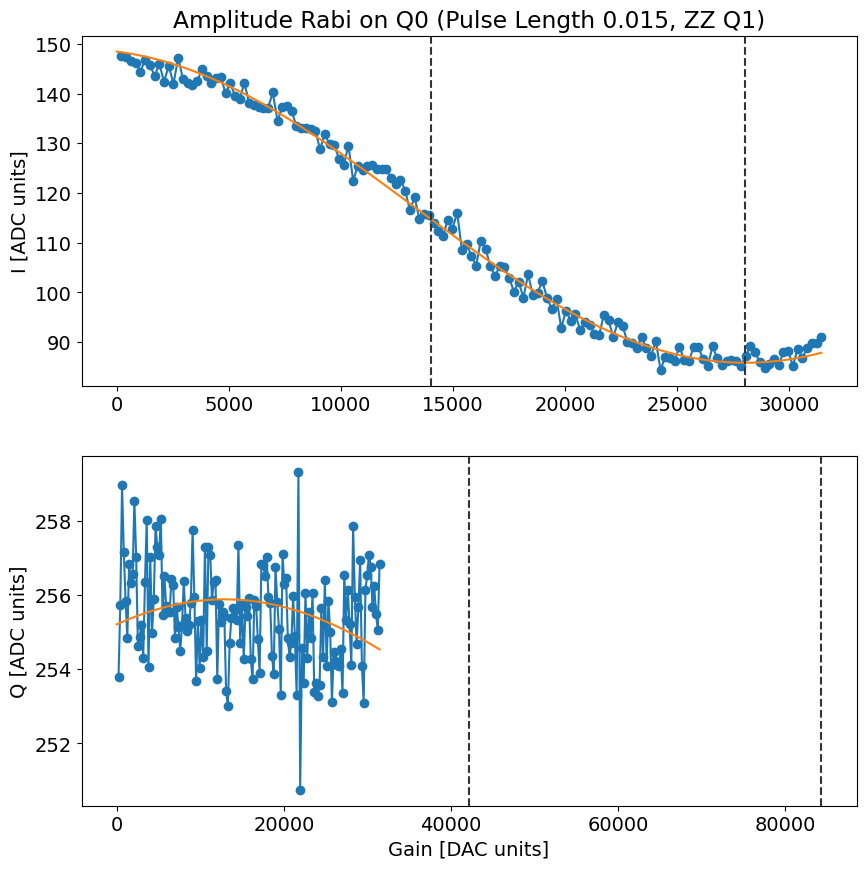

*Set Q0 pi pulse gain with Q1 in e to 28054*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00003_amp_rabi_qubit10.h5



-------- Amp rabi --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 11040
	Pi/2 gain from amps data [dac units]: 5520
Pi gain from avgi data [dac units]: 11063
	Pi/2 gain from avgi data [dac units]: 5531
Pi gain from avgq data [dac units]: 11098
	Pi/2 gain from avgq data [dac units]: 5549


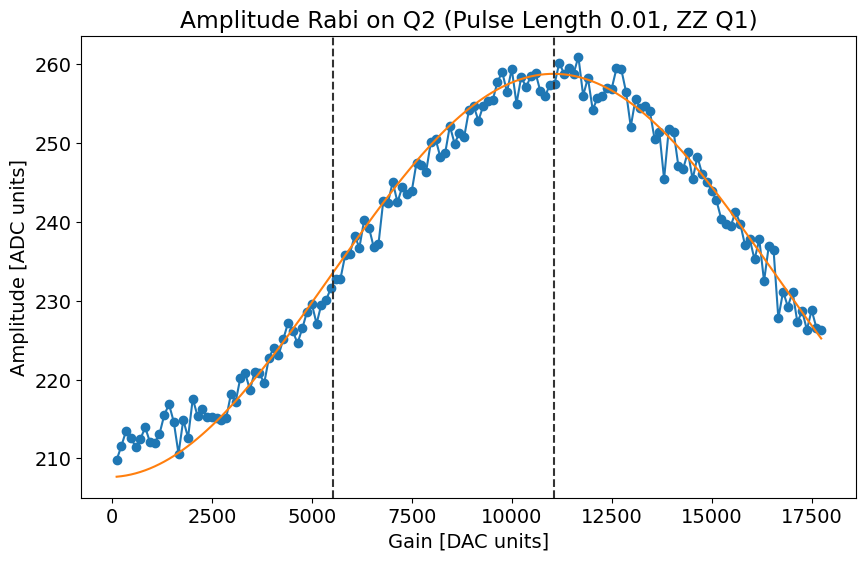

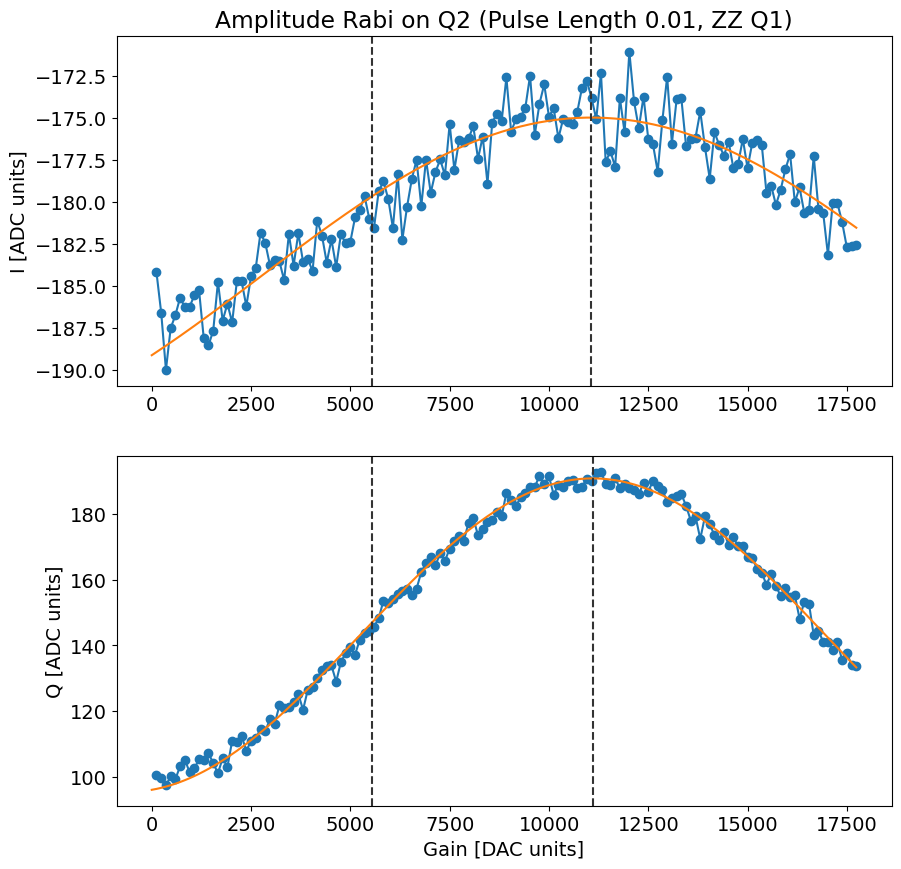

*Set Q2 pi pulse gain with Q1 in e to 11098*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00003_amp_rabi_qubit12.h5
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 4765.724536912047
Fit frequency from amps [MHz]: 1.9993314526075205 +/- 0.004347593379241866
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4765.72520545944
 	4761.72520545944
T2 Ramsey from fit amps [us]: 2.9065696061284036
Current pi pulse frequency: 4765.724536912047
Fit frequency from I [MHz]: 1.9932138468739469 +/- 0.0117893242347458
Suggested new pi pulse frequency from fit I [MHz]:
 	4765.7313230651735
 	4761.7313230651735
T2 Ramsey from fit I [us]: 1.8019367580801826
Fit frequency from Q [MHz]: 1.999839335916506 +/- 0.0038372237147368204
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4765.724697576131
 	4761.724697576131
T2 Ramsey from fit Q [us]: 3.0917301248433335


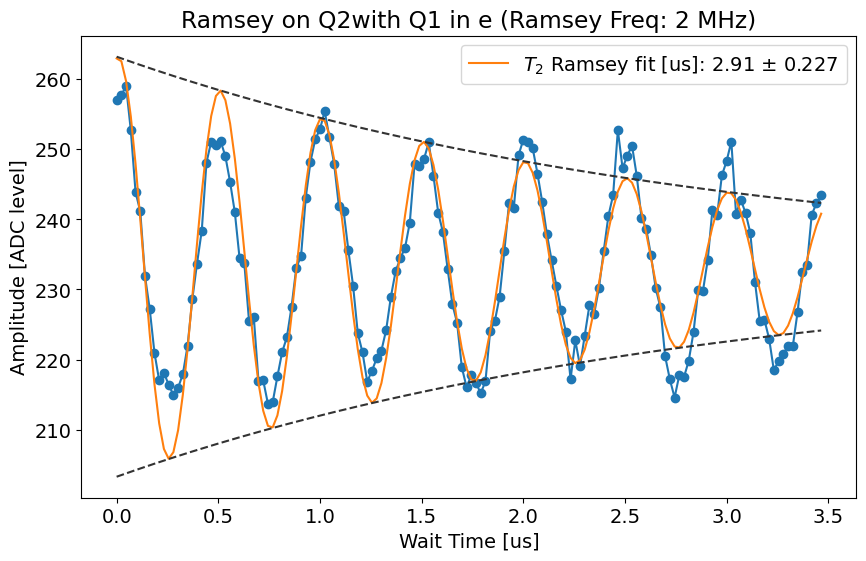

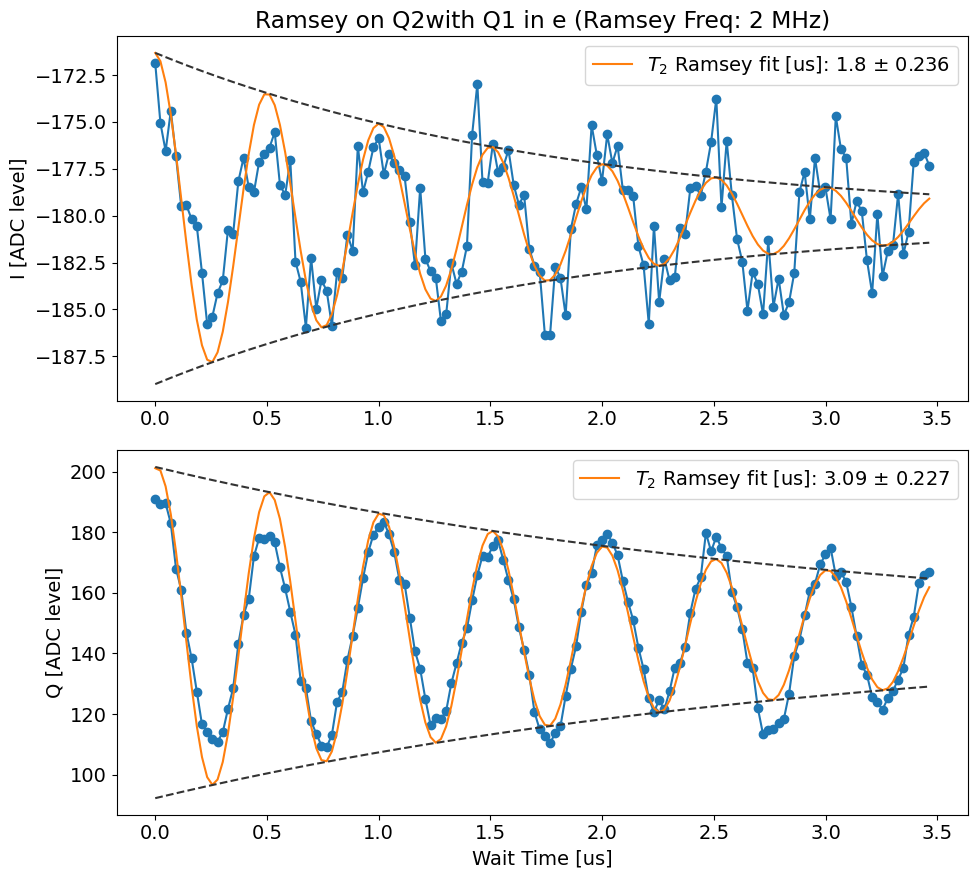

*Set Q2 pi pulse freq with Q1 in e to 4765.724697576131*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_ramsey_qubit12.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 11093
	Pi/2 gain from amps data [dac units]: 5546
Pi gain from avgi data [dac units]: 11322
	Pi/2 gain from avgi data [dac units]: 5661
Pi gain from avgq data [dac units]: 11157
	Pi/2 gain from avgq data [dac units]: 5578


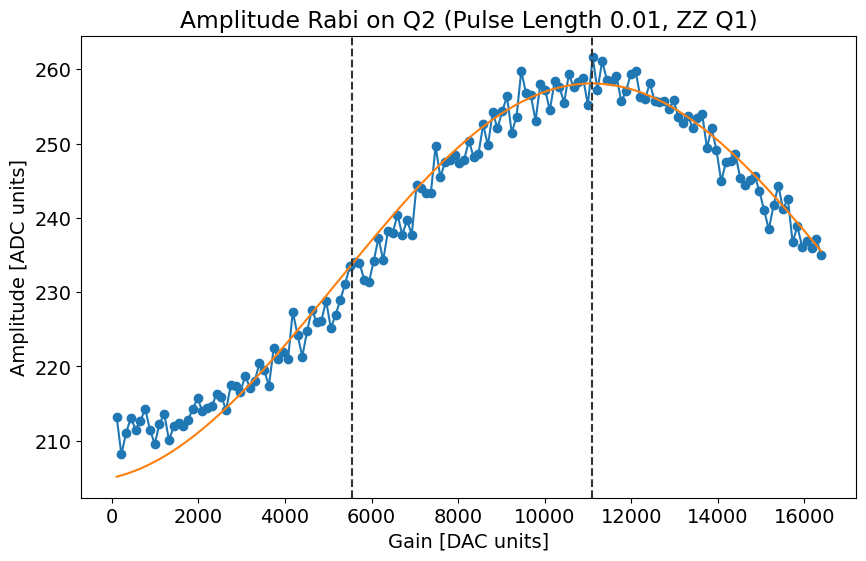

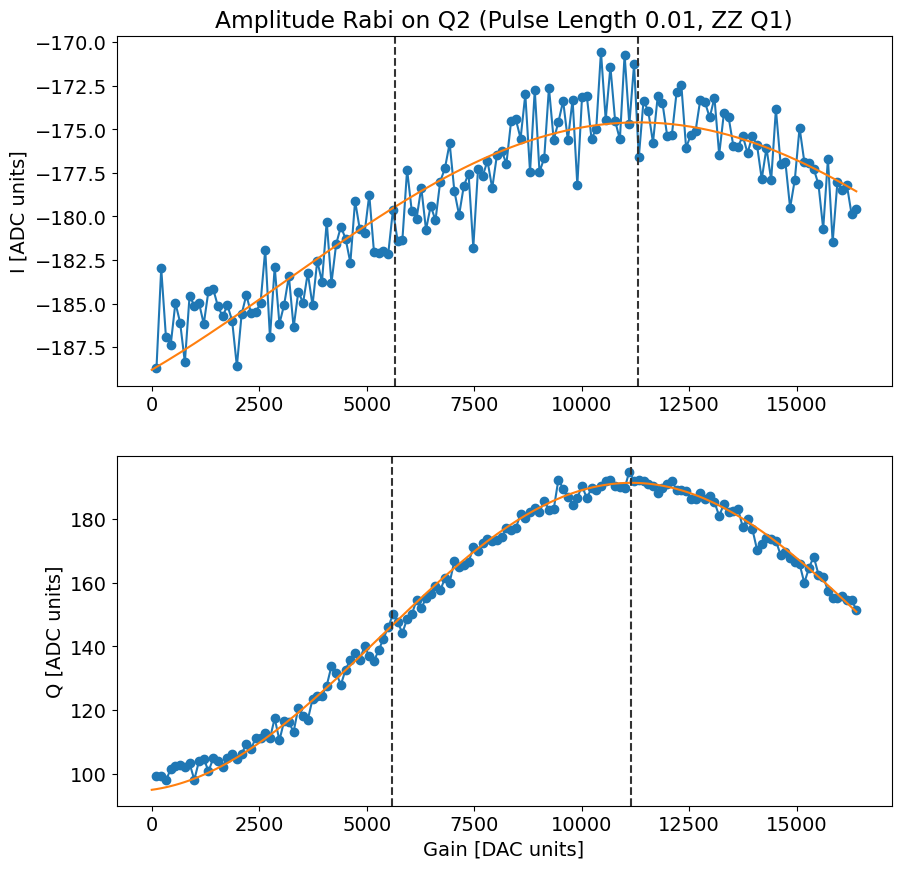

*Set Q2 pi pulse gain with Q1 in e to 11157*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00004_amp_rabi_qubit12.h5



-------- Amp rabi --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 1672
	Pi/2 gain from amps data [dac units]: 836
Pi gain from avgi data [dac units]: 3849
	Pi/2 gain from avgi data [dac units]: 1924
Pi gain from avgq data [dac units]: 3856
	Pi/2 gain from avgq data [dac units]: 1928


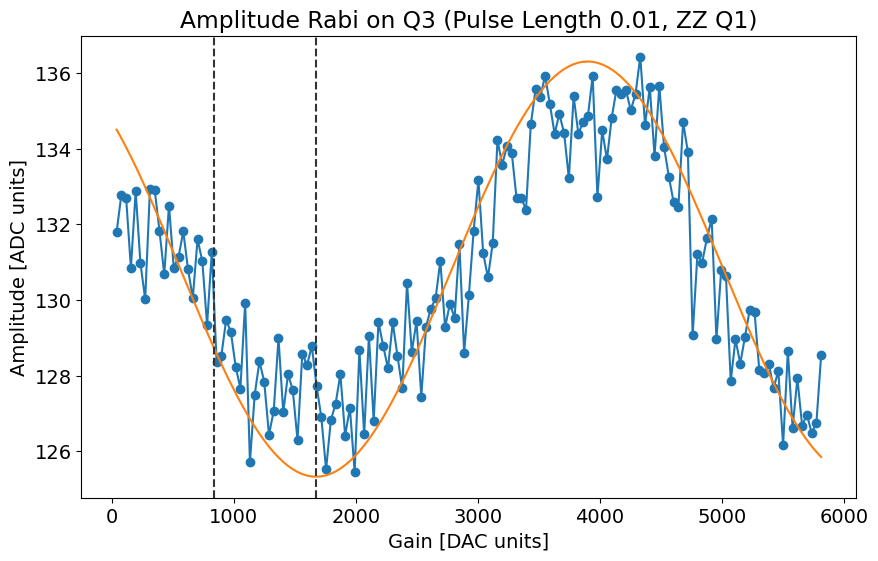

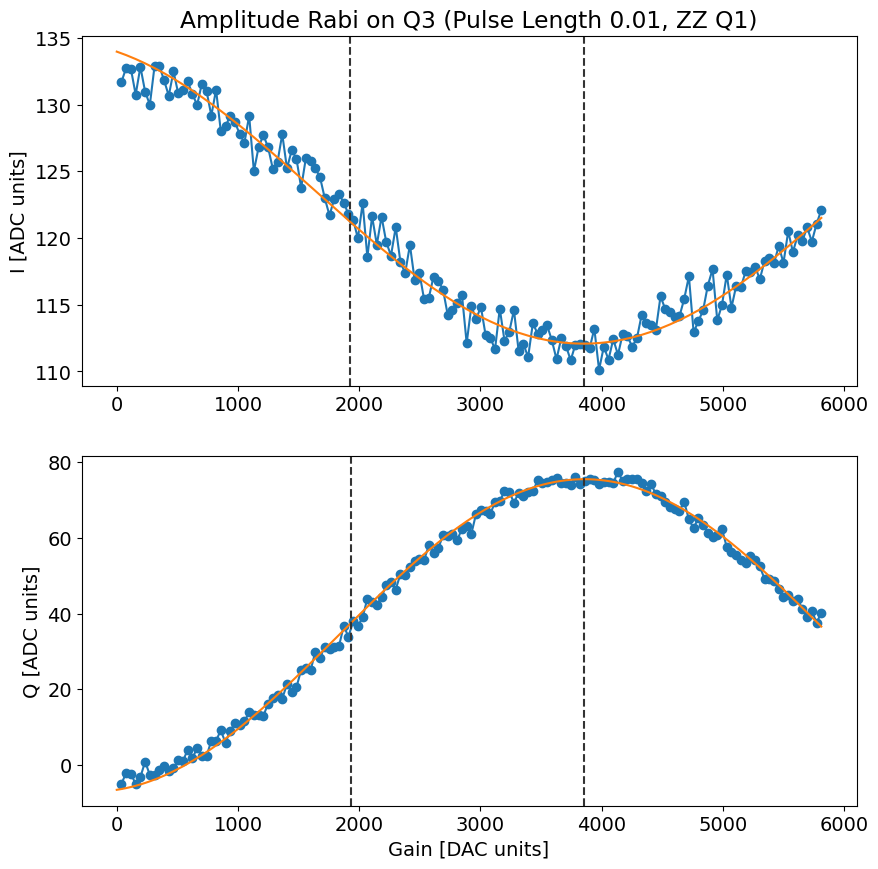

*Set Q3 pi pulse gain with Q1 in e to 3856*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_amp_rabi_qubit13.h5
-------- Ramsey --------


  0%|          | 0/10 [00:00<?, ?it/s]

Current pi pulse frequency: 4384.870206942213
Fit frequency from amps [MHz]: 1.9753547781192387 +/- 0.03509737886189481
Suggested new pi pulse frequencies from fit amps [MHz]:
 	4384.894852164094
 	4380.894852164094
T2 Ramsey from fit amps [us]: 1.039341517857143
Current pi pulse frequency: 4384.870206942213
Fit frequency from I [MHz]: 1.9912325591411526 +/- 0.0069317067244824915
Suggested new pi pulse frequency from fit I [MHz]:
 	4384.878974383072
 	4380.878974383072
T2 Ramsey from fit I [us]: 2.323530335000902
Fit frequency from Q [MHz]: 1.9962594032271956 +/- 0.0044322397954860175
Suggested new pi pulse frequencies from fit Q [MHz]:
 	4384.873947538987
 	4380.873947538987
T2 Ramsey from fit Q [us]: 3.367857116368979


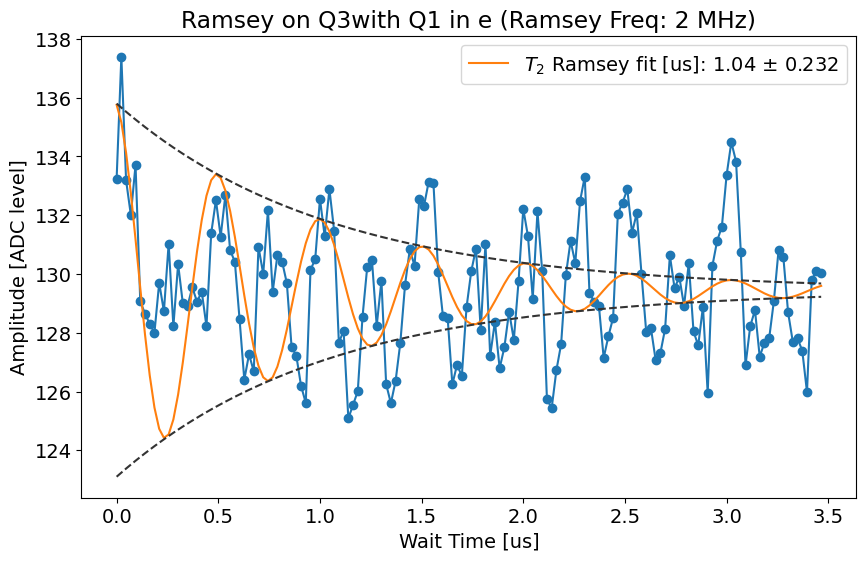

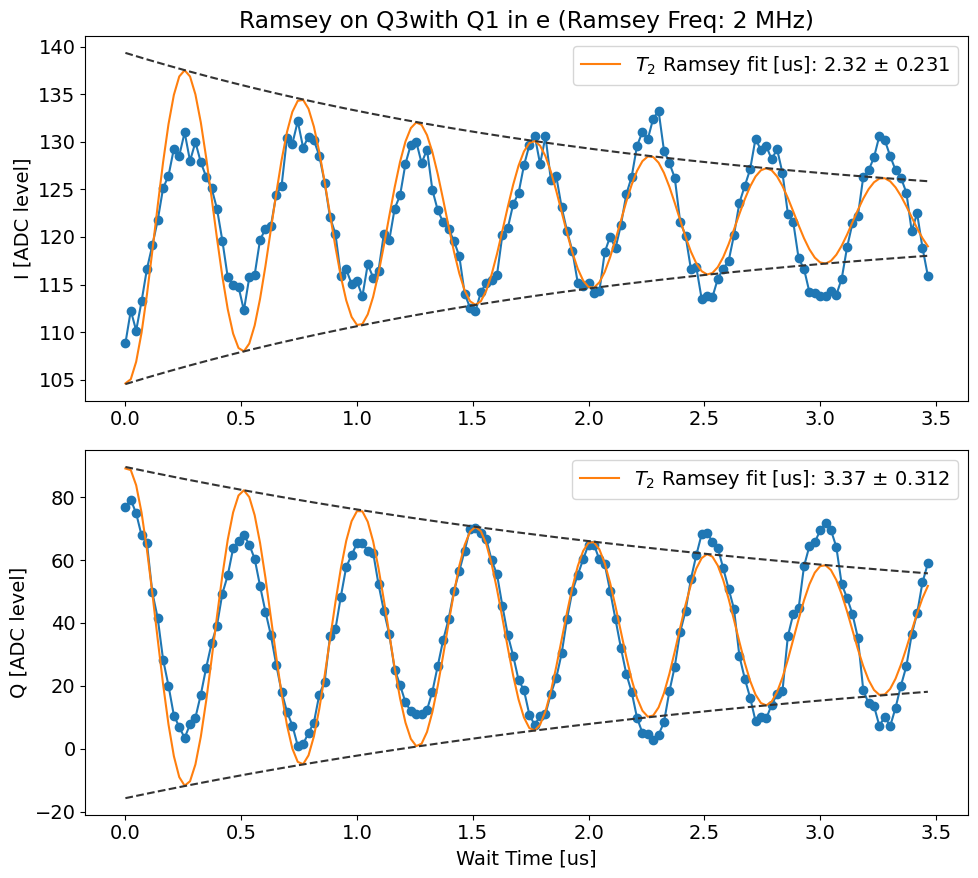

*Set Q3 pi pulse freq with Q1 in e to 4384.873947538987*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramsey_qubit13.h5
-------- Amp rabi round 2 --------


  0%|          | 0/10 [00:00<?, ?it/s]

Pi gain from amps data [dac units]: 25272
	Pi/2 gain from amps data [dac units]: 12636
Pi gain from avgi data [dac units]: 3902
	Pi/2 gain from avgi data [dac units]: 1951
Pi gain from avgq data [dac units]: 3858
	Pi/2 gain from avgq data [dac units]: 1929


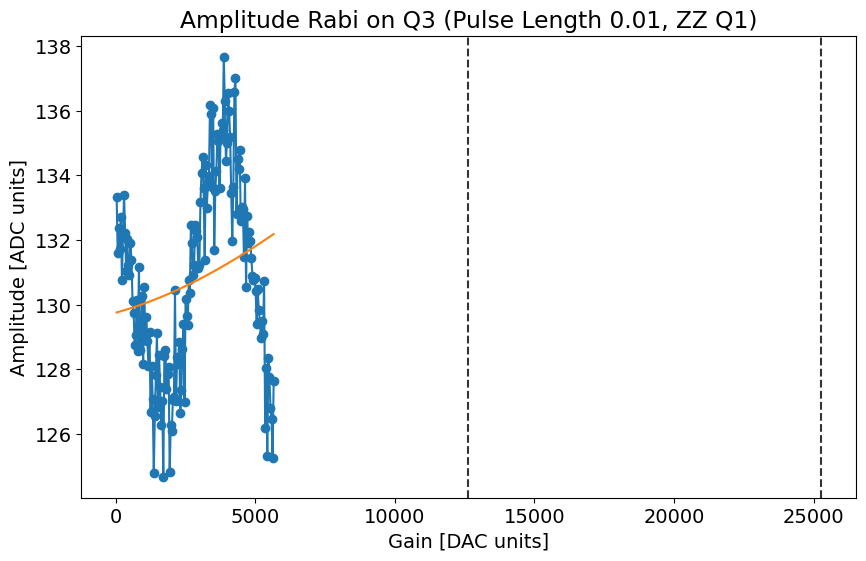

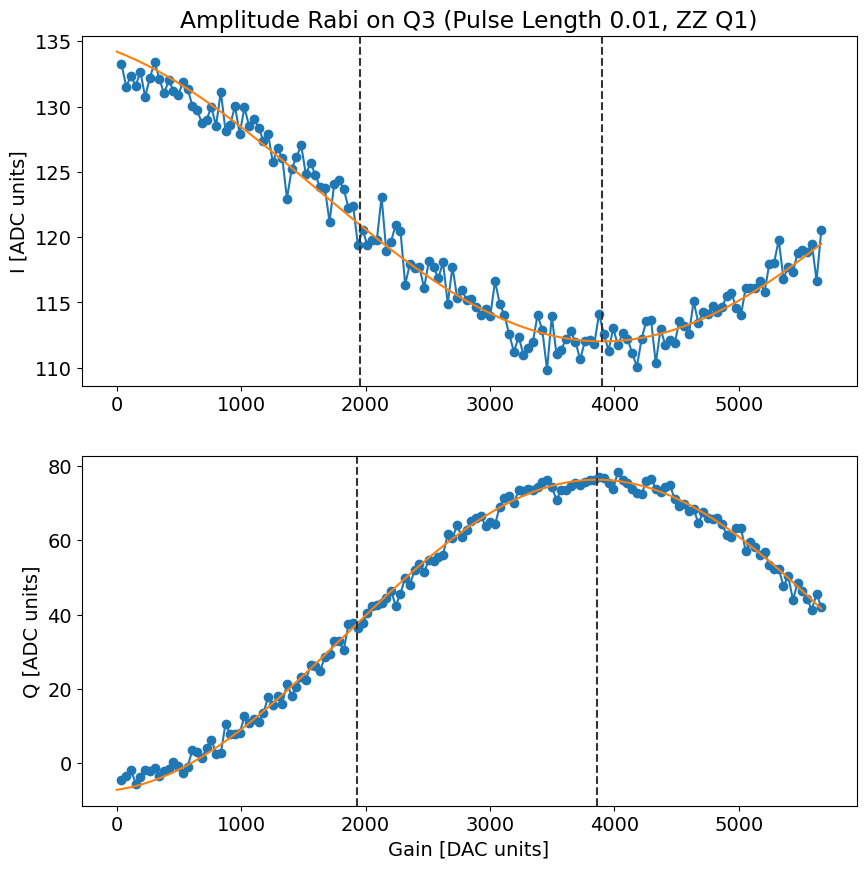

*Set Q3 pi pulse gain with Q1 in e to 3858*
Saving s:\Connie\experiments\qramLL_4QR2\data\data_231212\00003_amp_rabi_qubit13.h5





In [20]:
 # [x, 1] means test Q1 with ZZ from Qx; [1, x] means test Qx with ZZ from Q1, sort by Qx in both cases

try: save_data
except:
    assert False, 'you did not run the cell above!'
q0 = 1
# for qx in [0]:
for qx in range(4):
    if qx == q1: continue

    print(f"-------- Amp rabi --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{qx}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=80,
        rounds=10,
        sigma_test=yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx], # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, qx],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)

        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(pi_gain)
        results['gain'][qx] =  int(pi_gain)
        results['sigma'][qx] = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx]
        print(f'*Set Q{qx} pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {qx} (Q{q0} in e) !!!!!!!')
        continue

    # if qx < 2: continue
    print(f"-------- Ramsey --------")
    ramsey = meas.RamseyExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"ramsey_qubit{q0}{qx}",
        config_file=config_path,
    )
    ramsey.cfg = AttrDict(deepcopy(yaml_cfg))
    
    ramsey.cfg.expt = dict(
        start=0, # wait time tau [us]
        step=soc.cycles2us(10), # [us] make sure nyquist freq = 0.5 * (1/step) > ramsey (signal) freq!
        # step=0.05, # [us]
        expts=151,
        # expts=151,
        ramsey_freq=2, # [MHz]
        reps=80,
        rounds=10,
        checkZZ=True,
        checkEF=False,
        qubits=[q0, qx],
    )
    
    # ramsey.cfg.device.readout.relax_delay = 3*ramsey.cfg.device.qubit.T1[q1] # Wait time b/w expts [us]
    # ramsey.cfg.device.readout.gain = 0.15 # IT SEEMS HIGH PHOTON POPULATION CAN SOMETIMES MESS THIS UP
    
    try:
        ramsey.go(analyze=False, display=False, progress=True, save=False)
        ramsey.analyze(fit=True)

        ramsey_fit, ramsey_fit_err, ramsey_adjust = meas.fitting.get_best_fit(ramsey.data, get_best_data_params=['f_adjust_ramsey'])

        ramsey.display(fit=True)
        new_pi_freq = ramsey.cfg.device.qubit.f_Q_ZZ1[qx] + ramsey_adjust[0]
        yaml_cfg.device.qubit.f_Q_ZZ1[qx] = new_pi_freq
        print(f'*Set Q{qx} pi pulse freq with Q{q0} in e to {yaml_cfg.device.qubit.f_Q_ZZ1[qx]}*')
        results['f_Q_ZZ1'][qx] = new_pi_freq

        if save_data: saved_files.append(ramsey.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! RAMSEY FAILED ON QUBIT {qx} (Q{q0} in e)!!!!!!!')
        continue

    print(f"-------- Amp rabi round 2 --------")
    amprabi = meas.AmplitudeRabiExperiment(
        soccfg=soc,
        path=expt_path,
        prefix=f"amp_rabi_qubit{q0}{qx}",
        config_file=config_path,
    )
    amprabi.cfg = AttrDict(deepcopy(yaml_cfg))

    span = min((32000, 1.5*yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]))
    npts = 151

    amprabi.cfg.expt = dict(
        start=0, # qubit gain [dac level]
        step=int(span/npts), # [dac level]
        expts=npts,
        reps=80,
        rounds=10,
        sigma_test=yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx], # gaussian sigma for pulse length - overrides config [us]
        pulse_type='gauss',
        checkZZ=True,
        checkEF=False, 
        qubits=[q0, qx],
    )
    try:
        import Pyro4.util
        try:
            amprabi.go(analyze=False, display=False, progress=True, save=False)
        except Exception:
            print("Pyro traceback:")
            print("".join(Pyro4.util.getPyroTraceback()))

        amprabi.analyze(fit=True)

        amprabi_fit, amprabi_fit_err = meas.fitting.get_best_fit(amprabi.data)

        p = amprabi_fit
        if p[2] > 180: p[2] = p[2] - 360
        elif p[2] < -180: p[2] = p[2] + 360
        if p[2] < 0: pi_gain = (1/2 - p[2]/180)/2/p[1]
        else: pi_gain = (3/2 - p[2]/180)/2/p[1]

        if pi_gain > 32000:
            amprabi.display(fit=False)
            print('WARNING: Fit pi pulse gain is long, please double check!')
            pi_gain = 30000
        else: amprabi.display(fit=True)

        yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx] = int(pi_gain)
        results['gain'][qx] =  int(pi_gain)
        results['sigma'][qx] = yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.sigma[qx]
        print(f'*Set Q{qx} pi pulse gain with Q{q0} in e to {yaml_cfg.device.qubit.pulses.pi_Q_ZZ1.gain[qx]}*')

        if save_data: saved_files.append(amprabi.save_data())

    except Exception as e:
        print(e)
        print(f'!!!!!!! AMP RABI FAILED ON QUBIT {qx} (Q{q0} in e) !!!!!!!')
        continue

    
    print("\n\n")

In [21]:
print('pi_Q_ZZ1')
print(results)
for saved_file in saved_files:
    print(saved_file)

pi_Q_ZZ1
{'gain': [28054, 0, 11157, 3858], 'sigma': [0.015, 0, 0.01, 0.01], 'f_Q_ZZ1': [4110.652798026172, 0, 4765.724697576131, 4384.873947538987]}
None
s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramsey_qubit10.h5
None
None
s:\Connie\experiments\qramLL_4QR2\data\data_231212\00002_ramsey_qubit12.h5
None
None
s:\Connie\experiments\qramLL_4QR2\data\data_231212\00001_ramsey_qubit13.h5
None
